# HJB Optimal Control for Insurance Program Optimization

## A Teaching Guide: From Ergodic Theory to State-Dependent Insurance Decisions

This notebook teaches **Hamilton-Jacobi-Bellman (HJB) optimal control** applied to multi-layered insurance program design. It is written for junior actuaries, risk managers, and CFOs who want to understand *why* insurance premiums exceeding expected losses can still be optimal and how to compute the best possible insurance strategy.

### What we will do

- Optimize a **4-layer insurance program** for a **$5M manufacturing company** over a **25-year horizon**
- Use **Common Random Numbers (CRN)** to fairly compare strategies under identical loss scenarios
- Compare **HJB feedback control** (state-dependent) against traditional static strategies
- Explore how loss assumptions affect optimal strategy through **sensitivity analysis**
- Quantify the **cost of getting it wrong** -- why under-insuring is far more dangerous than over-insuring
- Validate results with **walk-forward out-of-sample testing**

### Prerequisites

- Basic probability and statistics
- Insurance concepts: retention (deductible), limits, layers, attachment points
- Familiarity with Python and NumPy is helpful but not strictly required

### Estimated runtime

15-30 minutes on Google Colab.

---

### Table of Contents

1. [Why Insurance Optimization Needs Optimal Control](#part1)
2. [Our Manufacturing Company](#part2)
3. [The 4-Layer Insurance Program](#part3)
4. [Why Expected Value Misleads (The Ergodic Insight)](#part4)
5. [How Insurance Fixes This](#part5)
6. [Introduction to HJB Optimal Control](#part6)
7. [Visualizing the Optimal Policy](#part7)
8. [25-Year Monte Carlo Strategy Comparison](#part8)
9. [How Loss Assumptions Drive Strategy (Sensitivity Analysis)](#part9)
10. [Walk-Forward Validation](#part10)
11. [The Cost of Getting It Wrong](#part11)
12. [Key Takeaways](#takeaways)
13. [Next Steps](#next-steps)

In [1]:
"""Google Colab setup: mount Drive and install package dependencies.

Run this cell first. If prompted to restart the runtime, do so, then re-run all cells.
This cell is a no-op when running locally.
"""
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

    NOTEBOOK_DIR = '/content/drive/My Drive/Colab Notebooks/ei_notebooks/optimization'

    os.chdir(NOTEBOOK_DIR)
    if NOTEBOOK_DIR not in sys.path:
        sys.path.append(NOTEBOOK_DIR)

    !pip install ergodic-insurance -q 2>&1 | tail -3
    print('\nSetup complete. If you see numpy/scipy import errors below,')
    print('restart the runtime (Runtime > Restart runtime) and re-run all cells.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Cloning https://github.com/AlexFiliakov/Ergodic-Insurance-Limits (to revision fix/notebook-07-ergodic-gap) to /tmp/pip-req-build-8polhzpt
  Running command git clone --filter=blob:none --quiet https://github.com/AlexFiliakov/Ergodic-Insurance-Limits /tmp/pip-req-build-8polhzpt
  Running command git checkout -b fix/notebook-07-ergodic-gap --track origin/fix/notebook-07-ergodic-gap
  Switched to a new branch 'fix/notebook-07-ergodic-gap'
  Branch 'fix/notebook-07-ergodic-gap' set up to track remote branch 'fix/notebook-07-ergodic-gap' from 'origin'.
  Resolved https://github.com/AlexFiliakov/Ergodic-Insurance-Limits to commit aebe7ebbc7dc1ad0fd9438971df9eb0d04eb21b4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

Setup complete. If you see numpy/scipy import errors below,


<a id="part1"></a>
## Part 1: Why Insurance Optimization Needs Optimal Control

### The insurance buyer's dilemma

You are the CFO of a mid-size manufacturer. Every year you face the same question: *how much insurance should we buy?* You have a premium budget, multiple layers to fill (primary, excess, catastrophic), and the wrong choice compounds over decades.

### The traditional approach and its flaw

The traditional actuarial approach picks retentions and limits based on **expected loss**. You calculate the expected annual loss, add a margin, and buy coverage accordingly. But there is a subtle, critical flaw:

> **Expected loss is not the same as time-average cost.**

Expected loss is an *ensemble average* -- the average over many hypothetical companies in parallel. But your company is not an ensemble. It is a single entity that must survive *sequentially through time*. The time-average cost can be dramatically different from the expected cost.

### Key insight preview

By the end of this notebook, you will see that **a policy costing 3x expected losses can still be optimal over 25 years**. This is not a paradox -- it is the consequence of the **multiplicative nature of wealth**: losses don't just subtract from your balance sheet, they compound through reduced reinvestment, missed opportunities, and increased borrowing costs.

The HJB equation gives us a principled mathematical framework for finding the *globally optimal* insurance at every wealth level and time point.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from concurrent.futures import ProcessPoolExecutor
import warnings
import logging
import time

# Suppress all warnings and verbose solver logging
warnings.filterwarnings("ignore")
logging.getLogger("ergodic_insurance").setLevel(logging.ERROR)

from ergodic_insurance.hjb_solver import (
    StateVariable, ControlVariable, StateSpace,
    LogUtility, PowerUtility, ExpectedWealth, TimeSteppingScheme,
    HJBProblem, HJBSolver, HJBSolverConfig, BoundaryCondition,
)
from ergodic_insurance.optimal_control import (
    ControlSpace, StaticControl, HJBFeedbackControl,
)
from ergodic_insurance.config import ManufacturerConfig
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.insurance_program import (
    EnhancedInsuranceLayer, InsuranceProgram,
)
from ergodic_insurance.loss_distributions import ManufacturingLossGenerator

plt.style.use("seaborn-v0_8-darkgrid")
SEED = 42
np.random.seed(SEED)
N_CORES = 40   # Available parallel cores for sensitivity sweep
CI = False      # Set True to skip heavy computations

<a id="part2"></a>
## Part 2: Our Manufacturing Company

We model a volatile manufacturing company with the following characteristics:

| Parameter | Value | Why it matters |
|---|---|---|
| Total assets | \$5M | Sets the scale of risk (a single large loss can be existential) |
| Asset turnover | 2.0x | Revenue = Assets * turnover = ~\$10M |
| Operating margin | 15% | \$3M Operating income (the "cushion" for absorbing losses) |
| Revenue volatility | 15% | Operational asset uncertainty |
| Tax rate | 25% | Tax shield reduces net cost of both premiums and retained losses |
| Earnings retention | 70% | 70% of after-tax profit reinvested for growth |
| Time horizon | 25 years | Long enough for ergodic effects to dominate |

This company earns only \$3M/year in operating income, but faces potential losses in the millions or tens of millions. A single bad year can set it back by a decade.

In [3]:
# --- Economic Parameters
ATR = 2.0                # Asset turnover ratio
OPERATING_MARGIN = 0.15  # 12% EBIT margin before Insurable Losses
REV_VOL = 0.50           # Revenue volatility (annualized)
INITIAL_ASSETS = 5_000_000

# --- Company Configuration ---
mfg_config = ManufacturerConfig(
    initial_assets=INITIAL_ASSETS,          # $15M total assets
    asset_turnover_ratio=ATR,               # Revenue = Assets Ãƒâ€” turnover = $22.5M
    base_operating_margin=OPERATING_MARGIN, # 12% EBIT margin -> $2.7M/yr operating income
    tax_rate=0.25,                          # 25% corporate tax
    retention_ratio=0.70,                   # 70% earnings retained for growth
)

# Display company profile
revenue = mfg_config.initial_assets * mfg_config.asset_turnover_ratio
ebit = revenue * mfg_config.base_operating_margin
print("=" * 60)
print("MANUFACTURING COMPANY PROFILE")
print("=" * 60)
print(f"Total Assets:          ${mfg_config.initial_assets:>14,.0f}")
print(f"Annual Revenue:        ${revenue:>14,.0f}")
print(f"Operating Income:      ${ebit:>14,.0f}")
print(f"Operating Margin:      {mfg_config.base_operating_margin:>14.1%}")
print(f"Asset Turnover:        {mfg_config.asset_turnover_ratio:>14.1f}x")
print(f"Revenue Volatility:    {REV_VOL:>14}")
print(f"Tax Rate:              {mfg_config.tax_rate:>13.1%}")
print(f"Retention Ratio:       {mfg_config.retention_ratio:>13.1%}")
print("=" * 60)

MANUFACTURING COMPANY PROFILE
Total Assets:          $     5,000,000
Annual Revenue:        $    10,000,000
Operating Income:      $     1,500,000
Operating Margin:               15.0%
Asset Turnover:                   2.0x
Revenue Volatility:               0.5
Tax Rate:                      25.0%
Retention Ratio:               70.0%


<a id="part3"></a>
## Part 3: The 4-Layer Insurance Program

A realistic commercial insurance program is built in **layers** that stack on top of each other:

```
                                          $100M  +-------------------+
                                                 |  Layer 4: CAT     |
                                                 |  $50M xs $50M     |
                                                 |  Rate: 0.2%       |
                                          $50M   +-------------------+
                                                 |  Layer 3: 2nd Xs  |
                                                 |  $25M xs $25M     |
                                                 |  Rate: 0.4%       |
                                          $25M   +-------------------+
                                                 |  Layer 2: 1st Xs  |
                                                 |  $20M xs $5M      |
                                                 |  Rate: 0.8%       |
                                          $5M    +-------------------+
                                                 |  Layer 1: Primary |
                                                 |  $4.75M xs $250K  |
                                                 |  Rate: 1.5%       |
                                          $250K  +-------------------+
                                                 | Self-Insured      |
                                          $0     | Retention (SIR)   |
                                                 +-------------------+
```

How losses flow through the tower:

- **Losses below \$250K**: Company pays in full (self-insured retention)
- **Losses \$250K - \$5M**: Layer 1 (Primary) responds -- this is the "working layer" with frequent claims
- **Losses \$5M - \$25M**: Layer 2 (1st Excess) picks up the excess
- **Losses \$25M - \$50M**: Layer 3 (2nd Excess) -- infrequent severe losses
- **Losses \$50M - \$100M**: Layer 4 (Catastrophic) -- rare but devastating events
- **Losses above \$100M**: Uninsured -- company bears full exposure

The premium rate (rate-on-line) decreases as you go higher because the probability of reaching that layer drops dramatically.

In [4]:
def create_insurance_program(retention_factor=1.0, limit_factor=1.0):
    """Create a 4-layer manufacturing insurance program.

    Rate-on-line will be tuned later in the simulation.

    Args:
        retention_factor: Multiplier on all attachment points (for optimization).
        limit_factor: Multiplier on all limits (for optimization).
    """
    layers = [
        # Layer 1: Primary (working layer)
        EnhancedInsuranceLayer(
            attachment_point=250_000 * retention_factor,
            limit=(5_000_000 - 250_000) * limit_factor,
            base_premium_rate=0.38,   # 38% rate-on-line (working layer)
            reinstatements=0,
        ),
        # Layer 2: First Excess
        EnhancedInsuranceLayer(
            attachment_point=5_000_000 * retention_factor,
            limit=20_000_000 * limit_factor,
            base_premium_rate=0.015,  # 1.5% rate-on-line
            reinstatements=1,
        ),
        # Layer 3: Second Excess
        EnhancedInsuranceLayer(
            attachment_point=25_000_000 * retention_factor,
            limit=25_000_000 * limit_factor,
            base_premium_rate=0.005,  # 0.5% rate-on-line
            reinstatements=2,
        ),
        # Layer 4: Catastrophic
        EnhancedInsuranceLayer(
            attachment_point=50_000_000 * retention_factor,
            limit=50_000_000 * limit_factor,
            base_premium_rate=0.002,  # 0.2% rate-on-line
            reinstatements=999,        # Effectively unlimited
        ),
    ]
    return InsuranceProgram(
        layers=layers,
        deductible=250_000 * retention_factor,
        name="Manufacturing 4-Layer Program",
    )


# Create baseline program
program = create_insurance_program()
summary = program.get_program_summary()

print("4-LAYER INSURANCE PROGRAM")
print("=" * 70)
print(f"{'Layer':<12} {'Attachment':>12} {'Limit':>12} {'Exhaust Pt':>12} {'Premium':>10}")
print("-" * 70)
for i, layer_info in enumerate(summary['layers']):
    print(f"Layer {i+1:<5}  ${layer_info['attachment']:>11,.0f} ${layer_info['limit']:>11,.0f} "
          f"${layer_info['exhaustion_point']:>11,.0f} ${layer_info['base_premium']:>9,.0f}")
print("-" * 70)
print(f"{'TOTAL':<12} {'':>12} {'':>12} {'':>12} ${summary['annual_base_premium']:>9,.0f}")
print(f"\nDeductible: ${summary['deductible']:,.0f}")
print(f"Total Coverage: ${summary['total_coverage']:,.0f}")

4-LAYER INSURANCE PROGRAM
Layer          Attachment        Limit   Exhaust Pt    Premium
----------------------------------------------------------------------
Layer 1      $    250,000 $  4,750,000 $  5,000,000 $1,805,000
Layer 2      $  5,000,000 $ 20,000,000 $ 25,000,000 $  300,000
Layer 3      $ 25,000,000 $ 25,000,000 $ 50,000,000 $  125,000
Layer 4      $ 50,000,000 $ 50,000,000 $100,000,000 $  100,000
----------------------------------------------------------------------
TOTAL                                               $2,330,000

Deductible: $250,000
Total Coverage: $99,750,000


### Shared Simulation Infrastructure

The cell below sets up four things used by every subsequent section:

1. **Amplified loss model** using the library's `ManufacturingLossGenerator` -- calibrated so the \$15M company faces significant expected annual losses relative to operating income, creating genuine existential risk.
2. **Analytical layer pricing** using the library's `LayerPricer` to compute actuarially sound premiums from the known severity distributions via limited expected values (LEVs). Rate-on-line adjusts naturally with retention: higher SIR at lower primary-layer ROL, producing the genuine cost-vs-variance tradeoff the HJB solver needs.
3. **Common Random Numbers (CRN)** -- pre-generated loss scenarios at a fixed reference revenue. Every strategy faces the *same storms*; the only difference is how each ship is built. Loss amounts are then **scaled by the square root of revenue** so that a growing company faces proportionally growing risks, keeping the economics consistent between insured and uninsured strategies.
4. **CRN simulation engine** -- processes scaled pre-generated losses through the library's `InsuranceProgram.process_claim()`, so retained losses are calculated correctly by the insurance tower. Premium is repriced at actual revenue with the same square-root scaling.

> **"Same storms, different ships."** By fixing the loss scenarios across strategies, even small differences in time-average growth become statistically significant. Without CRN, you would need 10x more paths to detect the same signal.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from concurrent.futures import ProcessPoolExecutor
import warnings
import logging
import time

# Suppress all warnings and verbose solver logging
warnings.filterwarnings("ignore")
logging.getLogger("ergodic_insurance").setLevel(logging.ERROR)

from ergodic_insurance.hjb_solver import (
    StateVariable, ControlVariable, StateSpace,
    LogUtility, PowerUtility, ExpectedWealth,
    HJBProblem, HJBSolver, HJBSolverConfig,
)
from ergodic_insurance.optimal_control import (
    ControlSpace, StaticControl, HJBFeedbackControl,
    TimeVaryingControl, OptimalController,
)
from ergodic_insurance.config import ManufacturerConfig
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.insurance_program import (
    EnhancedInsuranceLayer, InsuranceProgram,
)
from ergodic_insurance.loss_distributions import (
    ManufacturingLossGenerator, LognormalLoss, ParetoLoss,
)
from ergodic_insurance.insurance_pricing import LayerPricer

plt.style.use("seaborn-v0_8-darkgrid")
SEED = 42
np.random.seed(SEED)
N_CORES = 40   # Available parallel cores for sensitivity sweep
CI = False      # Set True to skip heavy computations

# =====================================================
# SHARED SIMULATION INFRASTRUCTURE
# =====================================================
# Used by Parts 5, 8, 9, 10, and 11.

# --- Economic Parameters ---
REFERENCE_REVENUE = ATR * INITIAL_ASSETS  # Fixed reference for loss calibration

# --- Loss Scaling ---
# Loss frequency (and CRN loss amounts) scale with the square root of
# revenue.  This keeps the loss drag proportional to the company's
# actual size for both insured and uninsured strategies.
FREQ_SCALING_EXPONENT = 0.75

# --- Amplified Loss Model ---
ATTR_BASE_FREQ = 2.5
ATTR_SEV_MEAN = 10_000
ATTR_SEV_CV = 5

LG_BASE_FREQ = 1.5
LG_SEV_MEAN = 450_000
LG_SEV_CV = 2.5

CAT_BASE_FREQ = 0.25
CAT_SEV_ALPHA = 2.05
CAT_SEV_XM = 800_000

LOSS_PARAMS = dict(
    attritional_params={'base_frequency': ATTR_BASE_FREQ,
                        'severity_mean': ATTR_SEV_MEAN,
                        'severity_cv': ATTR_SEV_CV,
                        'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                        'reference_revenue': REFERENCE_REVENUE},
    large_params={'base_frequency': LG_BASE_FREQ,
                  'severity_mean': LG_SEV_MEAN,
                  'severity_cv': LG_SEV_CV,
                  'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                  'reference_revenue': REFERENCE_REVENUE},
    catastrophic_params={'base_frequency': CAT_BASE_FREQ,
                         'severity_alpha': CAT_SEV_ALPHA,
                         'severity_xm': CAT_SEV_XM,
                         'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                         'reference_revenue': REFERENCE_REVENUE},
)

# Quick validation of the loss model
_val_gen = ManufacturingLossGenerator(**LOSS_PARAMS, seed=99)
_val_totals = []
SCENARIOS = 10_000
for _ in range(SCENARIOS):
    _events, _stats = _val_gen.generate_losses(duration=1.0, revenue=REFERENCE_REVENUE)
    _val_totals.append(_stats['total_amount'])
_expected_annual_loss = np.mean(_val_totals)
_operating_income = INITIAL_ASSETS * ATR * OPERATING_MARGIN
print(f"Loss model validation ({SCENARIOS:,.0f} one-year samples):")
print(f"  Expected annual loss:  ${_expected_annual_loss:>12,.0f}")
print(f"  Operating income:      ${_operating_income:>12,.0f}")
print(f"  Loss / Income ratio:   {_expected_annual_loss / _operating_income:.0%}")
print(f"  Std dev annual loss:   ${np.std(_val_totals):>12,.0f}")
print(f"  Max annual loss:       ${np.max(_val_totals):>12,.0f}")
del _val_gen, _val_totals, _events, _stats


# --- Analytical Layer Pricing via LEV ---
# Instead of hardcoded rate-on-line values, we compute actuarially sound
# premiums from the known severity distributions using limited expected
# values (LEVs).  For each layer (attachment a, limit l):
#
#   E[layer loss] = sum_i  freq_i * [LEV_i(a+l) - LEV_i(a)]
#   premium       = E[layer loss] / target_loss_ratio
#   rate_on_line  = premium / limit
#
# This ensures the primary-layer ROL decreases naturally as the SIR
# (retention) rises, producing the genuine cost-vs-variance tradeoff
# that the HJB solver needs.
#
# The pricers are parameterized so that the sensitivity analysis (Part 9)
# can adapt premiums to match the modified loss assumptions being tested.

TARGET_LOSS_RATIO = 0.85  # Soft-market loss ratio

def make_layer_pricers(large_freq=LG_BASE_FREQ,
                       large_sev_mean=LG_SEV_MEAN,
                       cur_revenue=REFERENCE_REVENUE):
    """Create a tuple of LayerPricers for a given loss parameterization.

    Frequency scales as (revenue / reference)^0.5, matching the loss
    model's sub-linear revenue scaling.  This keeps premium and loss
    scaling consistent so that insured and uninsured strategies face
    the same proportional cost growth.

    Args:
        large_freq: Large-loss annual frequency (default 1.0).
        large_sev_mean: Large-loss mean severity (default $1M).
        cur_revenue: Current revenue for frequency scaling.

    Returns:
        Tuple of (attritional, large, catastrophic) LayerPricers.
    """
    scale = (cur_revenue / REFERENCE_REVENUE) ** FREQ_SCALING_EXPONENT
    return (
        LayerPricer(LognormalLoss(mean=ATTR_SEV_MEAN, cv=ATTR_SEV_CV),
                    frequency=ATTR_BASE_FREQ * scale),
        LayerPricer(LognormalLoss(mean=large_sev_mean, cv=LG_SEV_CV),
                    frequency=large_freq * scale),
        LayerPricer(ParetoLoss(alpha=CAT_SEV_ALPHA, xm=CAT_SEV_XM),
                    frequency=CAT_BASE_FREQ * scale),
    )


# Default pricers for baseline loss model
DEFAULT_PRICERS = make_layer_pricers()


def analytical_layer_premium(attachment: float, limit: float,
                             pricers=None) -> float:
    """Compute actuarial premium for a layer using LEV-based expected losses.

    Premium = E[layer loss] / target_loss_ratio, where:
      E[layer loss] = sum over components of freq_i * (LEV_i(a+l) - LEV_i(a))

    Args:
        attachment: Layer attachment point.
        limit: Layer limit (width of coverage).
        pricers: Tuple of LayerPricers. Uses DEFAULT_PRICERS if None.
    """
    pricers = pricers or DEFAULT_PRICERS
    expected_loss = sum(p.expected_layer_loss(attachment, limit) for p in pricers)
    return expected_loss / TARGET_LOSS_RATIO


def analytical_rate_on_line(attachment: float, limit: float,
                            pricers=None) -> float:
    """Compute rate-on-line for a layer: premium / limit."""
    if limit <= 0:
        return 0.0
    return analytical_layer_premium(attachment, limit, pricers) / limit


# Validate: show how ROL varies across sample attachment points
print(f"\nAnalytical layer pricing (target LR = {TARGET_LOSS_RATIO:.0%}):")
print(f"  {'Attachment':>12s}  {'Limit':>12s}  {'E[Loss]':>12s}  {'Premium':>12s}  {'ROL':>8s}")
print(f"  {'-'*12}  {'-'*12}  {'-'*12}  {'-'*12}  {'-'*8}")
for _a, _l in [(10_000, 4_990_000), (25_000, 4_975_000), (50_000, 4_950_000),
               (250_000, 4_750_000), (1_000_000, 4_000_000),
               (2_000_000, 3_000_000), (4_000_000, 1_000_000),
               (5_000_000, 20_000_000), (25_000_000, 25_000_000), (50_000_000, 50_000_000)]:
    _el = analytical_layer_premium(_a, _l) * TARGET_LOSS_RATIO
    _p = analytical_layer_premium(_a, _l)
    _r = analytical_rate_on_line(_a, _l)
    print(f"  ${_a:>11,.0f}  ${_l:>11,.0f}  ${_el:>11,.0f}  ${_p:>11,.0f}  {_r:>7.2%}")


# --- Insurance Tower Factory ---
# Premium rates are computed analytically from the loss distribution,
# ensuring that the primary-layer ROL decreases with higher retention.
# The optional `pricers` argument lets the sensitivity analysis pass
# in LayerPricers built from alternative loss assumptions, so that
# premiums stay consistent with the loss environment being tested.

def make_program(sir: float, pricers=None) -> InsuranceProgram:
    """Create 4-layer tower with analytically priced premiums.

    Uses LEV-based layer pricing from severity distributions so that
    rate-on-line adjusts naturally with the retention level.

    Args:
        sir: Self-insured retention (deductible).
        pricers: Tuple of LayerPricers. Uses DEFAULT_PRICERS if None.

    Returns:
        InsuranceProgram with actuarially sound premium loading.
    """
    layer_defs = [
        # (base_attachment, ceiling, reinstatements)
        (sir,        5_000_000,   0),     # Primary (working layer)
        (5_000_000,  25_000_000,  1),     # 1st Excess
        (25_000_000, 50_000_000,  2),     # 2nd Excess
        (50_000_000, 100_000_000, 999),   # Cat
    ]
    layers = []
    for attach, ceiling, reinst in layer_defs:
        effective_attach = max(attach, sir)
        limit = ceiling - effective_attach
        if limit <= 0:
            continue
        rol = analytical_rate_on_line(effective_attach, limit, pricers)
        layers.append(EnhancedInsuranceLayer(
            attachment_point=effective_attach,
            limit=limit,
            base_premium_rate=rol,
            reinstatements=reinst,
        ))
    return InsuranceProgram(
        layers=layers,
        deductible=sir,
        name=f"Manufacturing Tower (SIR=${sir:,.0f})",
    )


# --- CRN: Pre-generate Loss Scenarios ---
def generate_loss_pool(n_paths, n_years, reference_revenue=REFERENCE_REVENUE, seed=SEED):
    """Pre-generate loss scenarios for Common Random Number comparison.

    All strategies will face the exact same loss events and revenue shocks.
    Losses are generated at a fixed reference revenue; the simulation
    engine then scales event amounts by (actual_revenue / reference)^0.5
    so that loss burden grows proportionally with the company.
    """
    ss = np.random.SeedSequence(seed)
    children = ss.spawn(n_paths + 1)

    # Shared revenue shocks
    rev_rng = np.random.default_rng(children[0])
    revenue_shocks = rev_rng.standard_normal((n_paths, n_years))

    # Per-path loss event sequences
    all_losses = []  # [path][year] -> List[LossEvent]
    for i in range(n_paths):
        gen = ManufacturingLossGenerator(
            **LOSS_PARAMS,
            seed=int(children[i + 1].generate_state(1)[0] % (2**31)),
        )
        path_losses = []
        for t in range(n_years):
            events, _ = gen.generate_losses(duration=1.0, revenue=reference_revenue)
            path_losses.append(events)
        all_losses.append(path_losses)

    return revenue_shocks, all_losses


# --- CRN Simulation Engine ---
def simulate_with_crn(sir, revenue_shocks, loss_pool, n_years=25,
                      initial_assets=INITIAL_ASSETS, pricers=None):
    """Simulate one static-SIR strategy across all CRN paths.

    Uses the library's InsuranceProgram.process_claim() to correctly
    allocate each loss through the insurance tower.

    Loss amounts from the CRN pool are scaled by
    (actual_revenue / REFERENCE_REVENUE)^FREQ_SCALING_EXPONENT so that
    the loss burden grows proportionally with the company.  Premium is
    repriced at actual revenue with the same exponent, keeping the
    cost-of-risk consistent between insured and uninsured strategies.

    Args:
        sir: Self-insured retention.
        revenue_shocks: Pre-generated revenue shocks (n_paths x n_years).
        loss_pool: Pre-generated loss events [path][year] -> List[LossEvent].
        n_years: Simulation horizon.
        initial_assets: Starting wealth.
        pricers: Tuple of LayerPricers for premium calculation.
            Uses DEFAULT_PRICERS if None (baseline loss assumptions).

    Returns:
        paths: array of shape (n_paths, n_years + 1) with asset values.
    """
    n_paths = len(loss_pool)
    paths = np.zeros((n_paths, n_years + 1))
    paths[:, 0] = initial_assets

    # Build program template and get fixed annual premium
    if sir >= 100_000_000:
        # "No insurance" -- skip tower entirely
        annual_premium = 0.0
        use_insurance = False
        program_template = None
    else:
        program_template = make_program(sir, pricers=pricers)
        annual_premium = program_template.calculate_premium()
        use_insurance = True

    for i in range(n_paths):
        assets = initial_assets
        for t in range(n_years):
            # Operating income with shared revenue shock
            revenue = assets * ATR * np.exp(
                REV_VOL * revenue_shocks[i, t] - 0.5 * REV_VOL**2
            )
            operating_income = revenue * OPERATING_MARGIN

            # Scale CRN losses to current revenue (sqrt scaling)
            loss_scale = (revenue / REFERENCE_REVENUE) ** FREQ_SCALING_EXPONENT

            # Process losses through insurance tower
            total_retained = 0.0
            if use_insurance:
                new_pricers = make_layer_pricers(cur_revenue=revenue)
                program_update = make_program(sir, pricers=new_pricers)
                annual_premium = program_update.calculate_premium()
                program = InsuranceProgram.create_fresh(program_update)
                for event in loss_pool[i][t]:
                    scaled_amount = event.amount * loss_scale
                    result = program.process_claim(scaled_amount)
                    total_retained += result.deductible_paid + result.uncovered_loss
            else:
                for event in loss_pool[i][t]:
                    total_retained += event.amount * loss_scale

            # Net income and asset update
            assets = assets + operating_income - total_retained - annual_premium
            assets = max(assets, 0.0)
            paths[i, t + 1] = assets

    return paths


# Pre-generate the main CRN pool used by Parts 5, 8, 10, 11
N_PATHS = 1_000
N_YEARS = 25
print(f"\nPre-generating CRN loss pool ({N_PATHS:,.0f} paths x {N_YEARS} years)...")
t0 = time.time()
CRN_SHOCKS, CRN_LOSSES = generate_loss_pool(n_paths=N_PATHS, n_years=N_YEARS)
print(f"  Done in {time.time() - t0:.1f}s")
print(f"  Shape: {CRN_SHOCKS.shape[0]:,} paths x {CRN_SHOCKS.shape[1]} years")

# Quick sanity: total losses per path-year
_annual_totals = [
    sum(e.amount for e in CRN_LOSSES[i][t])
    for i in range(100) for t in range(25)
]
print(f"  Mean annual loss (first 100 paths): ${np.mean(_annual_totals):,.0f}")
del _annual_totals

Loss model validation (10,000 one-year samples):
  Expected annual loss:  $   1,094,787
  Operating income:      $   1,500,000
  Loss / Income ratio:   73%
  Std dev annual loss:   $   1,750,790
  Max annual loss:       $  30,103,330

Analytical layer pricing (target LR = 85%):
    Attachment         Limit       E[Loss]       Premium       ROL
  ------------  ------------  ------------  ------------  --------
  $     10,000  $  4,990,000  $    989,205  $  1,163,771   23.32%
  $     25,000  $  4,975,000  $    959,744  $  1,129,110   22.70%
  $     50,000  $  4,950,000  $    918,047  $  1,080,055   21.82%
  $    250,000  $  4,750,000  $    696,982  $    819,978   17.26%
  $  1,000,000  $  4,000,000  $    297,860  $    350,424    8.76%
  $  2,000,000  $  3,000,000  $    125,165  $    147,253    4.91%
  $  4,000,000  $  1,000,000  $     21,992  $     25,872    2.59%
  $  5,000,000  $ 20,000,000  $     65,958  $     77,597    0.39%
  $ 25,000,000  $ 25,000,000  $      5,428  $      6,386   

<a id="part4"></a>
## Part 4: Why Expected Value Misleads (The Ergodic Insight)

This is the **most important conceptual section** of the notebook. Everything that follows builds on this insight.

### The coin flip that ruins you

Consider a bet: each year, a fair coin is flipped.
- **Heads (+50%)**: your wealth is multiplied by 1.50
- **Tails (-40%)**: your wealth is multiplied by 0.60

**Expected return per flip**: 0.5 x 1.50 + 0.5 x 0.60 = 1.05, which is **+5% per year**. Looks great!

But play this game 50 times:
- The **ensemble mean** (average across many players) grows at 5%/yr
- The **geometric mean** (typical single player) = sqrt(1.50 x 0.60) = sqrt(0.90) = 0.949, which is **-5.1% per year**
- After 50 years, the typical player has lost almost everything
- A few lucky players are fabulously rich, pulling the average up

This is the **ensemble vs time-average distinction**, and it is the core of ergodic theory.

### Connection to insurance

"Expected loss" is an ensemble average -- the average across many hypothetical companies in parallel. But a single company lives **one time path**, not the average of all paths.

Insurance reduces the variance of that single time path. By capping the downside, it increases the **geometric mean** (the time-average growth rate), even when the premium exceeds the expected loss.

Maximizing log utility = maximizing the geometric mean = the **Kelly criterion** for insurance. This is exactly what the HJB equation does.

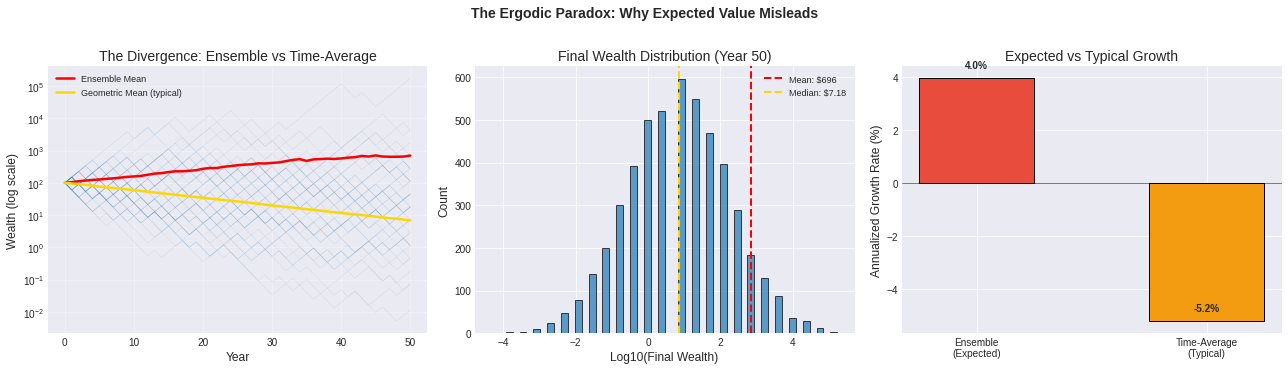


========================= SUMMARY ==========================
Expected per-flip return:  +4.0%  (looks profitable!)
Ensemble mean after 50y:  $         696
Typical outcome after 50y: $      7.1790
Fraction who went broke:   24.0%

This is exactly what happens to a company choosing insurance
based on expected loss instead of time-average growth rate.


In [6]:
# Demonstrate the ensemble vs time-average divergence
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=72)

# Panel 1: Sample wealth paths
n_paths = 5000
n_years_demo = 50
initial_wealth = 100

# Multiplicative process: +50% or -40% each year
np.random.seed(SEED)
wealth_paths = np.zeros((n_paths, n_years_demo + 1))
wealth_paths[:, 0] = initial_wealth

for t in range(n_years_demo):
    outcomes = np.where(np.random.random(n_paths) < 0.5, 1.50, 0.60)
    wealth_paths[:, t + 1] = wealth_paths[:, t] * outcomes

ax = axes[0]
for i in range(min(50, n_paths)):
    ax.semilogy(wealth_paths[i], alpha=0.15, color='steelblue', lw=0.5)
ax.semilogy(np.mean(wealth_paths, axis=0), 'r-', lw=2.5, label='Ensemble Mean')
ax.semilogy(
    np.exp(np.mean(np.log(np.maximum(wealth_paths, 1e-10)), axis=0)),
    'gold', lw=2.5, label='Geometric Mean (typical)',
)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Wealth (log scale)', fontsize=12)
ax.set_title('The Divergence: Ensemble vs Time-Average', fontsize=14)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 2: Histogram of final wealth
ax = axes[1]
final_wealth = wealth_paths[:, -1]
ax.hist(np.log10(np.maximum(final_wealth, 1e-10)), bins=50, edgecolor='black', alpha=0.7)
ax.axvline(np.log10(np.mean(final_wealth)), color='r', ls='--', lw=2,
           label=f'Mean: ${np.mean(final_wealth):,.0f}')
ax.axvline(np.log10(np.maximum(np.median(final_wealth), 1e-10)),
           color='gold', ls='--', lw=2,
           label=f'Median: ${np.median(final_wealth):,.2f}')
ax.set_xlabel('Log10(Final Wealth)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'Final Wealth Distribution (Year {n_years_demo})', fontsize=14)
ax.legend(fontsize=9)

# Panel 3: Growth rates
ax = axes[2]
ensemble_growth = np.mean(wealth_paths[:, -1]) / initial_wealth
time_avg_growth = np.exp(
    np.mean(np.log(np.maximum(wealth_paths[:, -1] / initial_wealth, 1e-20)))
)
growth_rates = {
    'Ensemble\n(Expected)': (ensemble_growth ** (1 / n_years_demo) - 1) * 100,
    'Time-Average\n(Typical)': (time_avg_growth ** (1 / n_years_demo) - 1) * 100,
}
colors = ['#e74c3c', '#f39c12']
bars = ax.bar(growth_rates.keys(), growth_rates.values(),
              color=colors, edgecolor='black', width=0.5)
ax.axhline(y=0, color='black', lw=0.5)
ax.set_ylabel('Annualized Growth Rate (%)', fontsize=12)
ax.set_title('Expected vs Typical Growth', fontsize=14)
for bar, val in zip(bars, growth_rates.values()):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3,
            f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.suptitle('The Ergodic Paradox: Why Expected Value Misleads',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\n{' SUMMARY ':=^60}")
print(f"Expected per-flip return:  +{(ensemble_growth ** (1 / n_years_demo) - 1) * 100:,.1f}%  (looks profitable!)")
print(f"Ensemble mean after {n_years_demo}y:  ${np.mean(final_wealth):>12,.0f}")
print(f"Typical outcome after {n_years_demo}y: ${np.median(final_wealth):>12,.4f}")
print(f"Fraction who went broke:   {np.mean(final_wealth < 1):.1%}")
print(f"{'':=^60}")
print(f"\nThis is exactly what happens to a company choosing insurance")
print(f"based on expected loss instead of time-average growth rate.")

<a id="part5"></a>
## Part 5: How Insurance Fixes This

Insurance transforms the multiplicative dynamics of your company's wealth. With significant expected annual losses and only \$2.7M in operating income, *most of the company's income is at risk every year*. A single bad year can wipe out a decade of accumulated profit.

We compare four strategies, all facing the **exact same loss scenarios** (Common Random Numbers). Loss amounts scale with the square root of revenue so that growing (or shrinking) companies face proportionally scaled risks:

| Strategy | SIR | What it means |
|---|---|---|
| No Insurance | -- | Company absorbs all losses |
| High SIR (\$1M) | \$1M | Only catastrophic losses covered |
| Moderate SIR (\$250K) | \$250K | Most large losses covered |
| Low SIR (\$25K) | \$25K | Comprehensive (nearly all losses covered) |

The key question: **is the expensive comprehensive insurance worth it?**

By the ensemble average (expected value), no. Expected losses are significant, and the premium loading adds cost. But the *time-average* tells a different story: comprehensive insurance dramatically improves the geometric mean growth rate, even though it costs more than the expected loss savings.

Strategy premiums (from library):
  No Insurance               (no insurance)
  High SIR ($1M)             SIR=$ 1,000,000  Premium=$   436,731/yr
  Moderate SIR ($250K)       SIR=$   250,000  Premium=$   906,285/yr
  Low SIR ($25K)             SIR=$    25,000  Premium=$ 1,215,417/yr

Simulating 4 strategies x 1,000 paths x 25 years (CRN) using 40 cores...
Done in 27.6s


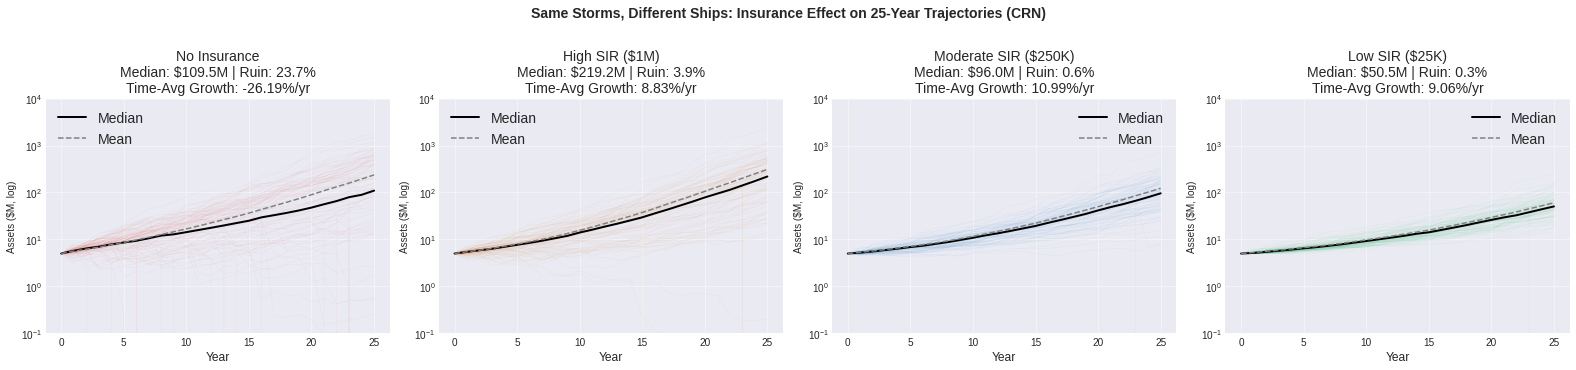


Strategy                  Median Final  Ruin Rate  Time-Avg Growth   Premium/yr
-------------------------------------------------------------------------------------
No Insurance              $     109.5M     23.7%           4.16%/yr $         0
High SIR ($1M)            $     219.2M      3.9%          13.89%/yr $   436,731
Moderate SIR ($250K)      $      96.0M      0.6%          12.04%/yr $   906,285
Low SIR ($25K)            $      50.5M      0.3%           9.57%/yr $ 1,215,417


In [7]:
# =====================================================
# Part 5: How Insurance Fixes This -- CRN Comparison
# =====================================================
n_sim = 1000
years = 25

# Define strategies: (label, SIR, color)
strategies = [
    ("No Insurance",        1_000_000_000, '#e74c3c'),   # SIR > any loss = uninsured
    ("High SIR ($1M)",      1_000_000,     '#e67e22'),
    ("Moderate SIR ($250K)",  250_000,     '#3498db'),
    ("Low SIR ($25K)",         25_000,     '#2ecc71'),
]

# Show premium for each insured strategy
print("Strategy premiums (from library):")
for label, sir, _ in strategies:
    if sir < 100_000_000:
        p = make_program(sir)
        print(f"  {label:<25s}  SIR=${sir:>10,.0f}  Premium=${p.calculate_premium():>10,.0f}/yr")
    else:
        print(f"  {label:<25s}  (no insurance)")

# --- Parallelized CRN Simulation ---
# Wrapper for parallel worker
def run_simulation_task(args):
    label, sir, shocks, losses, n_years = args
    # Note: simulate_with_crn uses global INITIAL_ASSETS by default if not passed,
    # but we pass what's needed or rely on defaults.
    paths = simulate_with_crn(sir, shocks, losses, n_years=n_years)
    return label, paths

print(f"\nSimulating {len(strategies)} strategies x {n_sim:,} paths x {years} years (CRN) using {N_CORES} cores...")
t0 = time.time()

# Prepare tasks
tasks = []
# We slice the shocks/losses to n_sim to avoid passing unnecessary data if n_sim < N_PATHS
shocks_slice = CRN_SHOCKS[:n_sim]
losses_slice = CRN_LOSSES[:n_sim]

for label, sir, _ in strategies:
    tasks.append((label, sir, shocks_slice, losses_slice, years))

# Execute in parallel
all_paths = {}
with ProcessPoolExecutor(max_workers=N_CORES) as executor:
    results = list(executor.map(run_simulation_task, tasks))

for label, paths in results:
    all_paths[label] = paths

print(f"Done in {time.time() - t0:.1f}s")

# --- Visualization ---
fig, axes = plt.subplots(1, 4, figsize=(22, 5), dpi=72)

for ax, (label, sir, color) in zip(axes, strategies):
    paths = all_paths[label]
    for i in range(min(100, n_sim)):
        ax.semilogy(paths[i] / 1e6, alpha=0.06, color=color, lw=0.5)
    ax.semilogy(np.median(paths, axis=0) / 1e6, color='black', lw=2, label='Median')
    ax.semilogy(np.mean(paths, axis=0) / 1e6, color='gray', ls='--', lw=1.5, label='Mean')

    final = paths[:, -1]
    ruined = np.mean(final < 1_000_000)
    geometric_growth = (
        np.exp(np.mean(np.log(np.maximum(final / INITIAL_ASSETS, 1e-20))))
        ** (1.0 / years) - 1
    )

    ax.set_title(
        f'{label}\nMedian: ${np.median(final)/1e6:.1f}M | Ruin: {ruined:.1%}\n'
        f'Time-Avg Growth: {geometric_growth:.2%}/yr',
        fontsize=14,
    )
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Assets ($M, log)')
    ax.legend(fontsize=14)
    ax.set_ylim(0.1, 10000)
    ax.grid(True, alpha=0.5)

plt.suptitle('Same Storms, Different Ships: Insurance Effect on 25-Year Trajectories (CRN)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary table
print("\n" + "=" * 85)
print(f"{'Strategy':<25} {'Median Final':>12} {'Ruin Rate':>10} "
      f"{'Time-Avg Growth':>16} {'Premium/yr':>12}")
print("-" * 85)
for label, sir, _ in strategies:
    paths = all_paths[label]
    final = paths[:, -1]
    ruined = np.mean(final < 1_000_000)
    g = np.exp(np.mean(np.log(np.maximum(final / INITIAL_ASSETS, .001)))) ** (1 / years) - 1
    prem = make_program(sir).calculate_premium() if sir < 100_000_000 else 0.0
    print(f"{label:<25} ${np.median(final)/1e6:>10.1f}M {ruined:>9.1%} "
          f"{g:>15.2%}/yr ${prem:>10,.0f}")
print("=" * 85)

<a id="part6"></a>
## Part 6: Introduction to HJB Optimal Control

### What is the HJB equation?

The Hamilton-Jacobi-Bellman equation is a recipe for finding the **best possible insurance** at every wealth level and time point. Think of it as **GPS routing for insurance decisions**: instead of picking a fixed route (static insurance), the HJB gives you turn-by-turn directions that adapt to your current position.

### The PDE

The HJB equation for our insurance problem is:

$$\frac{\partial V}{\partial t} + \max_{\text{SIR}} \left[ \mu(w, \text{SIR}) \cdot \frac{\partial V}{\partial w} + \frac{1}{2}\sigma^2(w, \text{SIR}) \cdot \frac{\partial^2 V}{\partial w^2} - \rho V + f(w) \right] = 0$$

where:

| Symbol | Meaning | Insurance interpretation |
|---|---|---|
| $V(w, t)$ | Value function | "How good is it to have wealth $w$ at time $t$?" |
| SIR | Control | Self-insured retention -- the one knob the company adjusts |
| $\mu(w, \text{SIR})$ | Drift | E[wealth growth] = operating income - premium - E[retained loss] |
| $\sigma^2(w, \text{SIR})$ | Diffusion | Wealth volatility = revenue risk + loss risk |
| $\rho$ | Discount rate | Time preference (how much we value the future) |
| $f(w)$ | Running reward | $\log(w)$ -- the Kelly/ergodic-optimal objective |

### Our single control: the SIR

We optimize **one number**: the self-insured retention (SIR). The rest of the insurance tower (4 layers from SIR up to \$100M) is fixed. This is realistic because in practice, a company negotiates the SIR while the broker fills in the tower above based on market conditions.

### Premium is a fixed dollar amount

The premium depends on the tower structure (which depends on SIR), **not** on the company's current wealth. While the losses may scale with wealth (as in this simulation), for given loss experience, A \$500K SIR program costs the same whether the company has \$5M or \$50M in assets. This creates realistic economics:

- For a **small company** (\$5M assets), the premium is a large fraction of income: expensive but potentially life-saving
- For a **large company** (\$50M assets), the same premium is cheap relative to income: easy to afford, but less critical

The HJB captures this tradeoff and tells us exactly when to increase the SIR as the company grows.

### How the solver works

1. **Pre-compute lookup tables** from the library: for each candidate SIR, we use `InsuranceProgram.process_claim()` on thousands of Monte Carlo loss samples to estimate the expected retained loss and its variance
2. **Start at year 25** (the terminal condition): V(w, T) = log(w)
3. **Step backwards in time**, at each step finding the SIR that maximizes the Hamiltonian
4. **Iterate** until the value function converges

The result is a **policy map**: for every (wealth, time) pair, we know the optimal SIR.

In [8]:
# =====================================================
# HJB PROBLEM SETUP -- 1D SIR Control
# =====================================================

# --- Step 1: Pre-compute lookup tables from the library ---
# For each candidate SIR, we use the library to compute:
#   - Annual premium (exact, from InsuranceProgram.calculate_premium)
#   - Expected retained loss (MC estimate via process_claim)
#   - Variance of retained loss (MC estimate)

sir_grid = np.geomspace(10_000, 4_000_000, 100)
premium_table = np.zeros(len(sir_grid))
expected_retained_table = np.zeros(len(sir_grid))
variance_retained_table = np.zeros(len(sir_grid))

print("Pre-computing insurance lookup tables from library...")
print(f"  SIR grid: ${sir_grid[0]:,.0f} to ${sir_grid[-1]:,.0f} ({len(sir_grid)} points)")

# Parallel worker function
def calculate_lookup_row(args):
    sir, seed = args
    # Instantiate local generator with unique seed
    gen = ManufacturingLossGenerator(**LOSS_PARAMS, seed=seed)

    prog = make_program(sir)
    premium = prog.calculate_premium()

    retained_samples = []
    for _ in range(100_000):
        events, _ = gen.generate_losses(1.0, REFERENCE_REVENUE)
        total_retained = 0.0
        fresh_prog = InsuranceProgram.create_fresh(prog)
        for ev in events:
            result = fresh_prog.process_claim(ev.amount)
            total_retained += result.deductible_paid + result.uncovered_loss
        retained_samples.append(total_retained)

    return premium, np.mean(retained_samples), np.var(retained_samples)

# Run parallel execution
print(f"Parallelizing lookup table generation over {N_CORES} cores...")
t0_lookup = time.time()
tasks = [(sir, 123 + k) for k, sir in enumerate(sir_grid)]

with ProcessPoolExecutor(max_workers=N_CORES) as executor:
    results = list(executor.map(calculate_lookup_row, tasks))

for k, (prem, exp_ret, var_ret) in enumerate(results):
    premium_table[k] = prem
    expected_retained_table[k] = exp_ret
    variance_retained_table[k] = var_ret

print(f"  Done in {time.time() - t0_lookup:.1f}s")

print(f"\n  {'SIR':>12s}  {'Premium':>12s}  {'E[Retained]':>12s}  {'Std[Retained]':>14s}")
print(f"  {'-'*12}  {'-'*12}  {'-'*12}  {'-'*14}")
for idx in [0, len(sir_grid)//4, len(sir_grid)//2, 3*len(sir_grid)//4, -1]:
    print(f"  ${sir_grid[idx]:>11,.0f}  ${premium_table[idx]:>11,.0f}  "
          f"${expected_retained_table[idx]:>11,.0f}  "
          f"${np.sqrt(variance_retained_table[idx]):>13,.0f}")

# --- Step 2: Define HJB dynamics using lookup tables ---

# State space: wealth x time
state_variables = [
    StateVariable(
        name="wealth",
        min_value=1_000_000,       # $1M minimum (near-insolvency)
        max_value=200_000_000,     # $200M maximum (successful growth)
        num_points=500,
        log_scale=True,
        boundary_lower=BoundaryCondition.DIRICHLET,
        boundary_upper=BoundaryCondition.ABSORBING,
    ),
]
state_space = StateSpace(state_variables)

# Single control: SIR
control_variables = [
    ControlVariable(
        name="sir",
        min_value=10_000,
        max_value=4_000_000,
        num_points=100,
        log_scale=True,
    ),
]

utility = LogUtility()


def company_dynamics(state, control, t):
    """Wealth drift: operating income - premium - E[retained loss].

    Premium and expected retained loss scale with revenue via the
    frequency scaling exponent, so risk cost grows sub-linearly with
    the company.  Returns a 1-D array (one drift value per state point).
    """
    wealth = state[..., 0]
    sir = control[..., 0]

    # Operating income: wealth * ATR * margin
    operating_income = wealth * ATR * OPERATING_MARGIN

    # Revenue-based scaling for premium and losses
    revenue = wealth * ATR
    scaling = (revenue / REFERENCE_REVENUE) ** FREQ_SCALING_EXPONENT

    # Premium and E[retained] at reference revenue, scaled to current
    premium = np.interp(sir, sir_grid, premium_table) * scaling
    expected_retained = np.interp(sir, sir_grid, expected_retained_table) * scaling

    # Net drift (1-D: wealth dimension only)
    return operating_income - premium - expected_retained


def company_diffusion(state, control, t):
    """Wealth volatility sigma^2: revenue risk + retained-loss risk.

    Returns a 1-D array (one variance value per state point).
    """
    wealth = state[..., 0]
    sir = control[..., 0]

    # Revenue volatility (proportional to wealth)
    rev_variance = (wealth * ATR * OPERATING_MARGIN * REV_VOL) ** 2

    # Loss volatility scales with revenue
    revenue = wealth * ATR
    scaling = (revenue / REFERENCE_REVENUE) ** FREQ_SCALING_EXPONENT
    loss_variance = np.interp(sir, sir_grid, variance_retained_table) * scaling**2

    # Total variance (approximately independent)
    return rev_variance + loss_variance


def running_reward(state, control, t):
    return utility.evaluate(state[..., 0])

def terminal_value(state):
    return utility.evaluate(state[..., 0])


# Assemble HJB problem
hjb_problem = HJBProblem(
    state_space=state_space,
    control_variables=control_variables,
    utility_function=utility,
    dynamics=company_dynamics,
    running_cost=running_reward,
    terminal_value=terminal_value,
    discount_rate=0.03, # Inflation is not factored in, so this is roughly NPV growth
    time_horizon=25.0,
    diffusion=company_diffusion,
)

solver_config = HJBSolverConfig(
    time_step=0.005,
    max_iterations=800,
    inner_max_iterations=2000,
    tolerance=1e-4,
    verbose=True,
    scheme=TimeSteppingScheme.IMPLICIT,
)

# SOLVE
if not CI:
    print("\nSolving HJB equation for optimal SIR strategy...")
    print(f"State space: {state_space.shape} ({state_space.size:,} points)")
    print(f"SIR grid: {control_variables[0].num_points} values from "
          f"${control_variables[0].min_value:,.0f} to ${control_variables[0].max_value:,.0f}")
    print()

    t_start = time.time()
    hjb_solver = HJBSolver(hjb_problem, solver_config)
    value_function, optimal_policy = hjb_solver.solve()

    solve_time = time.time() - t_start

    print(f"\nSolved in {solve_time:.1f} seconds")
    print(f"Value function shape: {value_function.shape}")
    print(f"Policy keys: {list(optimal_policy.keys())}")

    cm = hjb_solver.compute_convergence_metrics()
    print(f"Max HJB residual: {cm['max_residual']:.4e}")
    print(f"Mean HJB residual: {cm['mean_residual']:.4e}")

    # Quick check: policy at starting wealth
    wealth_grid = state_space.grids[0]
    w_idx = np.searchsorted(wealth_grid, INITIAL_ASSETS)
    w_idx = min(w_idx, len(wealth_grid) - 1)
    print(f"\nOptimal SIR at starting wealth (${mfg_config.initial_assets / 1e6:,.0f}M), t=0: "
          f"${optimal_policy['sir'][w_idx]:,.0f}")
else:
    print("CI mode -- HJB solve skipped.")


Pre-computing insurance lookup tables from library...
  SIR grid: $10,000 to $4,000,000 (100 points)
Parallelizing lookup table generation over 40 cores...
  Done in 13.9s

           SIR       Premium   E[Retained]   Std[Retained]
  ------------  ------------  ------------  --------------
  $     10,000  $  1,250,078  $     26,555  $       15,542
  $     45,403  $  1,174,835  $     93,454  $      668,080
  $    206,144  $    951,699  $    281,849  $      815,173
  $    935,961  $    461,531  $    704,370  $    1,648,092
  $  4,000,000  $    112,179  $  1,001,884  $    1,917,286

Solving HJB equation for optimal SIR strategy...
State space: (500,) (500 points)
SIR grid: 100 values from $10,000 to $4,000,000


Solved in 93.7 seconds
Value function shape: (500,)
Policy keys: ['sir']
Max HJB residual: 1.5636e+01
Mean HJB residual: 9.3573e-02

Optimal SIR at starting wealth ($5M), t=0: $377,577


<a id="part6b"></a>
## Part 6b: Anatomy of the HJB Solution

Before looking at the optimal policy itself, let's dissect **what the solver is actually optimizing**. The HJB equation balances four competing forces at every wealth level:

$$\underbrace{\mu(w, \text{SIR}^*) \cdot \frac{\partial V}{\partial w}}_{\text{Growth benefit}} + \underbrace{\frac{1}{2}\sigma^2(w, \text{SIR}^*) \cdot \frac{\partial^2 V}{\partial w^2}}_{\text{Risk penalty}} + \underbrace{f(w)}_{\text{Running reward}} \underbrace{- \rho V}_{\text{Discount cost}} = -\frac{\partial V}{\partial t}$$

To understand these forces, we first need the **partial derivatives of the value function** -- the two quantities that translate wealth dynamics into "value dynamics."

### Why the derivatives matter

| Derivative | Meaning | Insurance implication |
|---|---|---|
| $\frac{\partial V}{\partial w}$ | Marginal value of wealth -- how much one extra dollar is "worth" | High for small companies &#8594; insurance saves dollars that matter most |
| $\frac{\partial^2 V}{\partial w^2}$ | Concavity / risk aversion -- how quickly marginal value declines | More negative &#8594; variance is more costly &#8594; insurance is more valuable |

The concavity of $V$ is the **engine of insurance demand**. If $V$ were linear ($\partial^2 V/\partial w^2 = 0$), variance wouldn't matter and no rational agent would pay a premium above expected loss. The fact that $\partial^2 V/\partial w^2 < 0$ means that symmetric gambles have asymmetric value consequences, meaning losses hurt more than equivalent gains help.

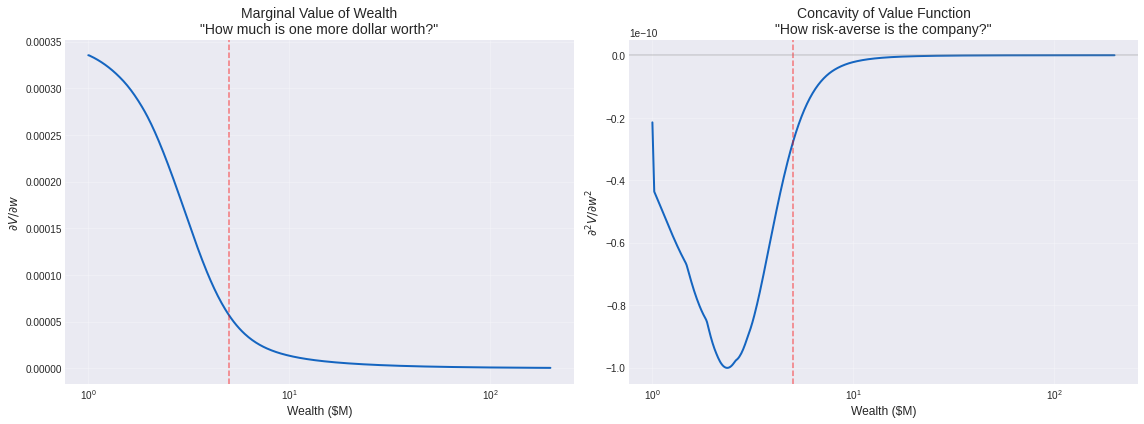


Observations:
  At starting wealth ($5M), t=0:
    dV/dw  = 5.6735e-05  (each dollar is worth this much "value")
    d2V/dw2 = -2.7606e-11  (negative = risk-averse)
  At $1M (near-insolvency):
    dV/dw  = 3.3535e-04  (5.9x starting wealth)
  At $200M (successful growth):
    dV/dw  = 4.0572e-07  (0.0x starting wealth)


In [9]:
if not CI:
    # =====================================================
    # PARTIAL DERIVATIVES OF THE VALUE FUNCTION
    # =====================================================
    wealth_grid = state_space.grids[0]

    # dV/dw: marginal value of wealth (finite differences on log-spaced grid)
    dVdw = np.gradient(value_function, wealth_grid, axis=0)

    # d2V/dw2: concavity (risk aversion)
    d2Vdw2 = np.gradient(dVdw, wealth_grid, axis=0)

    # Time snapshots
    t_indices = [0]
    t_labels = ["t = 0 (start)"]
    colors = ["#1565C0"]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=72)

    # --- Panel 1: dV/dw (marginal value of wealth) ---
    ax = axes[0]
    for ti, tl, c in zip([t_indices[0]], [t_labels[0]], [colors[0]]):
        ax.semilogx(wealth_grid / 1e6, dVdw, color=c, lw=2)
    ax.axvline(INITIAL_ASSETS / 1e6, color="red", ls="--", alpha=0.5,
              label=f"Starting wealth (${INITIAL_ASSETS/1e6:.0f}M)")
    ax.set_xlabel("Wealth ($M)", fontsize=12)
    ax.set_ylabel(r"$\partial V / \partial w$", fontsize=12)
    ax.set_title("Marginal Value of Wealth\n"
               '"How much is one more dollar worth?"', fontsize=14)
    # ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    # --- Panel 2: d2V/dw2 (concavity / risk aversion) ---
    ax = axes[1]
    for ti, tl, c in zip([t_indices[0]], [t_labels[0]], [colors[0]]):
        ax.semilogx(wealth_grid / 1e6, d2Vdw2, color=c, lw=2)
    ax.axvline(INITIAL_ASSETS / 1e6, color="red", ls="--", alpha=0.5,
              label=f"Starting wealth (${INITIAL_ASSETS/1e6:.0f}M)")
    ax.axhline(0, color="gray", ls="-", alpha=0.3)
    ax.set_xlabel("Wealth ($M)", fontsize=12)
    ax.set_ylabel(r"$\partial^2 V / \partial w^2$", fontsize=12)
    ax.set_title("Concavity of Value Function\n"
               '"How risk-averse is the company?"', fontsize=14)
    # ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nObservations:")
    w_start_idx = np.searchsorted(wealth_grid, INITIAL_ASSETS)
    w_start_idx = min(w_start_idx, len(wealth_grid) - 1)
    print(f"  At starting wealth (${INITIAL_ASSETS/1e6:.0f}M), t=0:")
    print(f"    dV/dw  = {dVdw[w_start_idx]:.4e}  (each dollar is worth this much \"value\")")
    print(f"    d2V/dw2 = {d2Vdw2[w_start_idx]:.4e}  (negative = risk-averse)")
    print(f"  At $1M (near-insolvency):")
    print(f"    dV/dw  = {dVdw[0]:.4e}  ({dVdw[0]/dVdw[w_start_idx]:.1f}x starting wealth)")
    print(f"  At ${wealth_grid[-1]/1e6:.0f}M (successful growth):")
    print(f"    dV/dw  = {dVdw[-1]:.4e}  ({dVdw[-1]/dVdw[w_start_idx]:.1f}x starting wealth)")


### The four forces of the Hamiltonian

Now we evaluate each term of the Hamiltonian **at the optimal SIR** that the solver chose. This reveals the forces that compete at every wealth level:

1. **Growth benefit** $\mu(w, \text{SIR}^*) \cdot \frac{\partial V}{\partial w}$: The drift (operating income minus premium minus expected retained loss) multiplied by how much each dollar of drift matters. Higher SIR &#8594; lower premium &#8594; more drift, but also more retained loss.

2. **Risk penalty** $\frac{1}{2}\sigma^2(w, \text{SIR}^*) \cdot \frac{\partial^2 V}{\partial w^2}$: Variance times concavity. Always **negative** (variance destroys value for a concave $V$). Higher SIR &#8594; more loss variance &#8594; larger penalty. This is the term that creates insurance demand.

3. **Running reward** $f(w) = \log(w)$: The instantaneous utility of being at wealth $w$. Independent of the SIR, it just reflects how good the current position is.

4. **Discount cost** $-\rho V$: The time-preference penalty. Future value is discounted at rate $\rho = 3\%$, so higher $V$ means a larger discount cost. This creates urgency: the company should act sooner rather than later.

**The optimal SIR** at each wealth level is the one that maximizes the sum of these four terms. In practice, this means balancing the **growth benefit** (wants high SIR to save premium) against the **risk penalty** (wants low SIR to reduce variance).

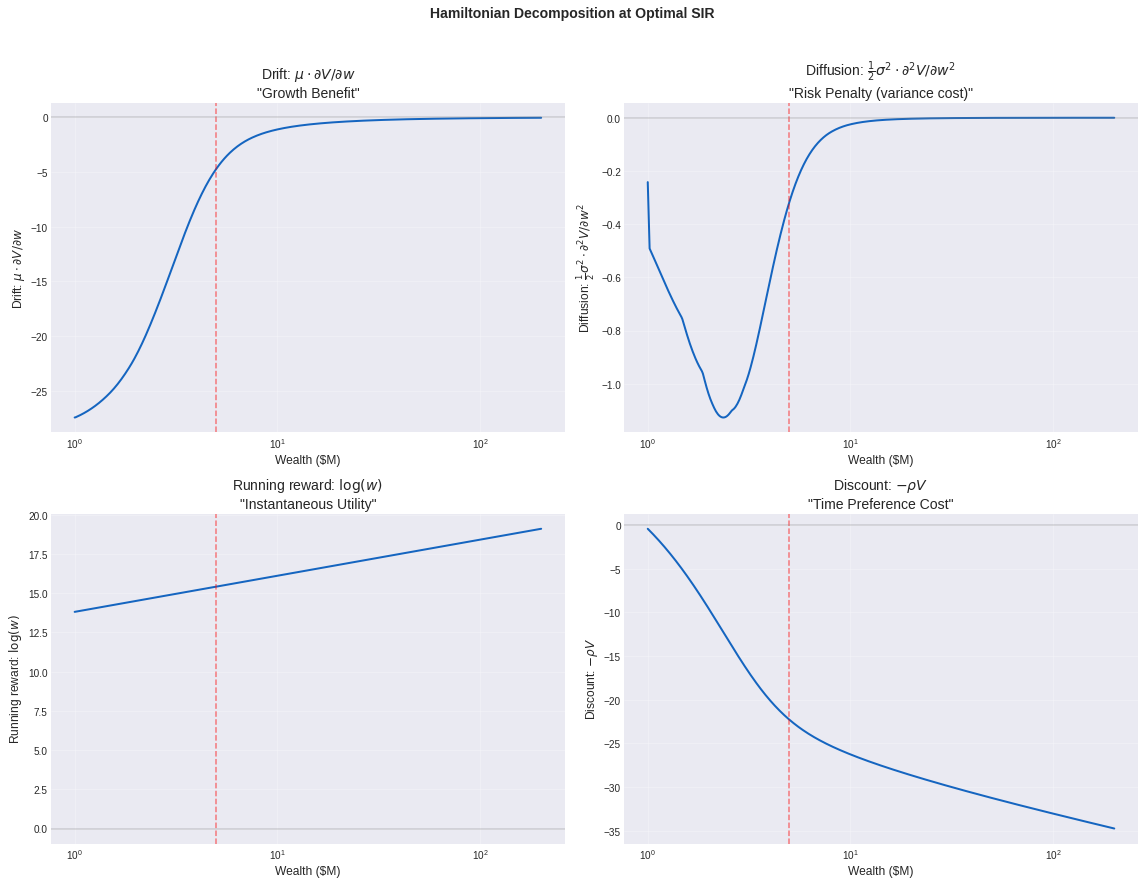

  Growth benefit (mu * dV/dw):           -4.6411
  Risk penalty (0.5*sig2*d2V/dw2):       -0.3109
  Running reward (log w):                +15.4294
  Discount cost (-rho V):                -22.3317
  ---------------------------------------------
  Net Hamiltonian (= -dV/dt):            -11.8542


In [10]:
if not CI:
    # =====================================================
    # HAMILTONIAN DECOMPOSITION AT OPTIMAL POLICY
    # =====================================================

    # Evaluate dynamics at the optimal SIR on the full wealth grid
    state_array = np.stack([wealth_grid], axis=-1)
    opt_sir = optimal_policy["sir"]
    control_array = opt_sir[..., np.newaxis]

    # Term 1: Growth benefit = mu(w, SIR*) * dV/dw
    drift_all = company_dynamics(state_array, control_array, 0.0)
    drift_w = drift_all[..., 0]       # wealth component of drift
    growth_benefit = drift_w * dVdw

    # Term 2: Risk penalty = 0.5 * sigma^2(w, SIR*) * d2V/dw2
    sigma_sq_all = company_diffusion(state_array, control_array, 0.0)
    sigma_sq_w = sigma_sq_all[..., 0]  # wealth component of diffusion
    risk_penalty = 0.5 * sigma_sq_w * d2Vdw2

    # Term 3: Running reward = log(w)
    running_rwd = np.log(wealth_grid)

    # Term 4: Discount cost = -rho * V
    rho = hjb_problem.discount_rate
    discount_cost = -rho * value_function

    # ---- Figure 2: Four Hamiltonian terms ----
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=72)

    panels = [
        (growth_benefit, r"Drift: $\mu \cdot \partial V/\partial w$",
         "Growth Benefit", "#1565C0"),
        (risk_penalty, r"Diffusion: $\frac{1}{2}\sigma^2 \cdot \partial^2 V/\partial w^2$",
         "Risk Penalty (variance cost)", "#C62828"),
        (running_rwd, r"Running reward: $\log(w)$",
         "Instantaneous Utility", "#2E7D32"),
        (discount_cost, r"Discount: $-\rho V$",
         "Time Preference Cost", "#6A1B9A"),
    ]

    for ax, (term, math_label, subtitle, base_color) in zip(axes.flat, panels):
        for ti, tl, c in zip([t_indices[0]], [t_labels[0]], [colors[0]]):
            ax.semilogx(wealth_grid / 1e6, term, color=c, lw=2)
        ax.axvline(INITIAL_ASSETS / 1e6, color="red", ls="--", alpha=0.5)
        ax.axhline(0, color="gray", ls="-", alpha=0.3)
        ax.set_xlabel("Wealth ($M)", fontsize=12)
        ax.set_ylabel(math_label, fontsize=12)
        ax.set_title(f'''{math_label}
"{subtitle}"''', fontsize=14)
        # ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    plt.suptitle("Hamiltonian Decomposition at Optimal SIR",
               fontsize=14, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()

    # Print values at starting wealth
    # print("Hamiltonian terms at starting wealth, t=0:")
    print(f"  Growth benefit (mu * dV/dw):      {growth_benefit[w_start_idx]:>+12.4f}")
    print(f"  Risk penalty (0.5*sig2*d2V/dw2):  {risk_penalty[w_start_idx]:>+12.4f}")
    print(f"  Running reward (log w):            {running_rwd[w_start_idx]:>+12.4f}")
    print(f"  Discount cost (-rho V):            {discount_cost[w_start_idx]:>+12.4f}")
    net = (growth_benefit[w_start_idx] + risk_penalty[w_start_idx]
           + running_rwd[w_start_idx] + discount_cost[w_start_idx])
    print(f"  {'':->45}")
    print(f"  Net Hamiltonian (= -dV/dt):        {net:>+12.4f}")

### Balance of forces across wealth

The most revealing view is to overlay all four terms on the same axes at different time snapshots. This shows:

- **Where growth benefit dominates**: at high wealth, the drift term is large because operating income scales with assets. Insurance is less critical here.
- **Where risk penalty bites hardest**: at low wealth, the concavity of $V$ is steepest, so variance carries a huge penalty. This is where insurance is essential.
- **The crossover point**: the wealth level where the growth benefit and risk penalty roughly balance determines the transition from "must insure aggressively" to "can self-insure more."

The **net Hamiltonian** (dashed black line) equals $-\partial V/\partial t$ is the rate of change of the value function over time. When it's large and positive, the company is in a "high-value trajectory" where current wealth is being efficiently converted into future value.

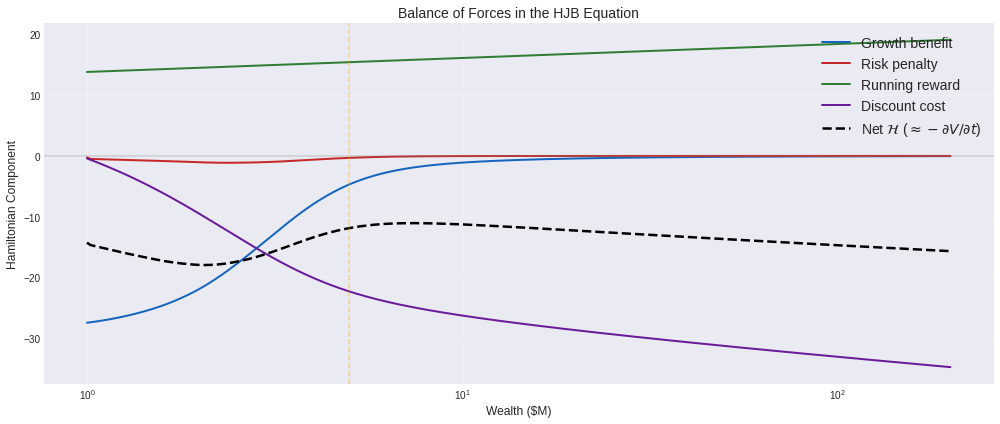

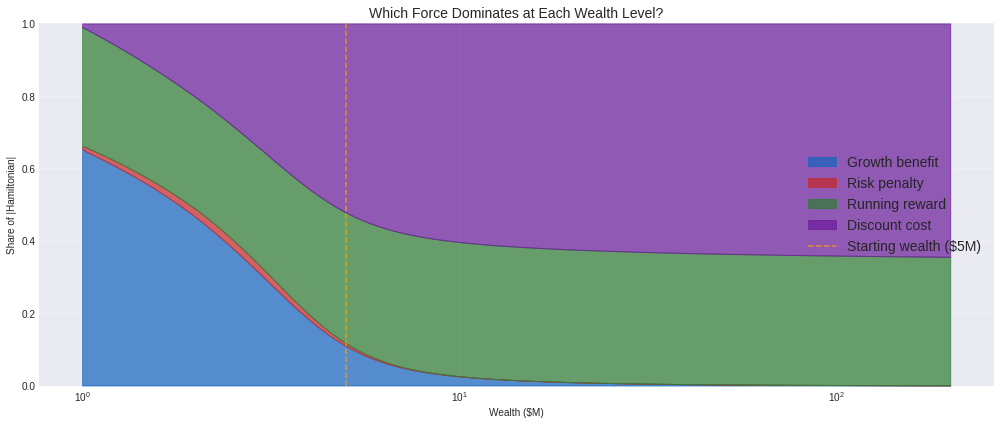

In [18]:
if not CI:
    # =====================================================
    # BALANCE OF FORCES: ALL TERMS OVERLAID
    # =====================================================

    fig, axes = plt.subplots(figsize=(14, 6), dpi=72)

    for ax, (ti, tl) in zip([axes], zip([t_indices[0]], [t_labels[0]])):
        ax.semilogx(wealth_grid / 1e6, growth_benefit,
                    lw=2, color="#1565C0", label="Growth benefit")
        ax.semilogx(wealth_grid / 1e6, risk_penalty,
                    lw=2, color="#C62828", label="Risk penalty")
        ax.semilogx(wealth_grid / 1e6, running_rwd,
                    lw=2, color="#2E7D32", label="Running reward")
        ax.semilogx(wealth_grid / 1e6, discount_cost,
                    lw=2, color="#6A1B9A", label="Discount cost")

        # Net Hamiltonian
        net_H = (growth_benefit + risk_penalty
                 + running_rwd + discount_cost)
        ax.semilogx(wealth_grid / 1e6, net_H,
                    lw=2.5, ls="--", color="black",
                    label=r"Net $\mathcal{H}$ ($\approx -\partial V/\partial t$)")

        ax.axvline(INITIAL_ASSETS / 1e6, color="orange", ls="--", alpha=0.4)
        ax.axhline(0, color="gray", ls="-", alpha=0.3)
        ax.set_xlabel("Wealth ($M)", fontsize=12)
        ax.set_ylabel("Hamiltonian Component", fontsize=12)
        ax.set_title('Balance of Forces in the HJB Equation', fontsize=14)
        ax.legend(fontsize=14, loc="best")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- Dominance map: which term has the largest absolute magnitude? ---
    fig, ax = plt.subplots(figsize=(14, 6), dpi=72)

    term_names = ["Growth benefit", "Risk penalty", "Running reward", "Discount cost"]
    term_colors = ["#1565C0", "#C62828", "#2E7D32", "#6A1B9A"]
    all_terms_t0 = np.stack([
        np.abs(growth_benefit),
        np.abs(risk_penalty),
        np.abs(running_rwd),
        np.abs(discount_cost),
    ], axis=-1)  # (n_wealth, 4)

    # Normalize to fractions
    row_sums = all_terms_t0.sum(axis=1, keepdims=True)
    fractions = all_terms_t0 / np.maximum(row_sums, 1e-12)

    # Stacked area chart
    bottom = np.zeros(len(wealth_grid))
    for j, (name, color) in enumerate(zip(term_names, term_colors)):
        ax.fill_between(wealth_grid / 1e6, bottom, bottom + fractions[:, j],
                       color=color, alpha=0.7, label=name)
        bottom += fractions[:, j]

    ax.axvline(INITIAL_ASSETS / 1e6, color="orange", ls="--", alpha=0.7,
              label=f"Starting wealth (${INITIAL_ASSETS/1e6:.0f}M)")
    ax.set_xscale("log")
    ax.set_xlabel("Wealth ($M)")
    ax.set_ylabel("Share of |Hamiltonian|")
    ax.set_title('Which Force Dominates at Each Wealth Level?',
               fontsize=14)
    ax.set_ylim(0, 1)
    ax.legend(loc="center right", fontsize=14)
    ax.grid(True, alpha=0.3, axis="y")
    plt.tight_layout()
    plt.show()


<a id="part7"></a>
## Part 7: Visualizing the Optimal Policy

Now we examine what the HJB solver found. With a single control (the SIR), the policy is easy to visualize:

1. **Value function** V(w, t=0): shows the diminishing marginal value of additional wealth. The concavity of this curve is exactly *why* insurance is valuable -- losing \$5M hurts more than gaining \$5M helps.

2. **Optimal SIR vs wealth**: THE key result. Small companies should buy comprehensive coverage (low SIR); large companies can afford higher retentions. The curve should be monotonically increasing.

3. **Implied premium-to-expected-loss ratio**: shows how much the company "overpays" relative to expected losses. Even at 3-5x expected loss, the insurance is worth it.

4. **Effective retained-loss volatility vs wealth**: shows how insurance reduces exposure to loss variance.

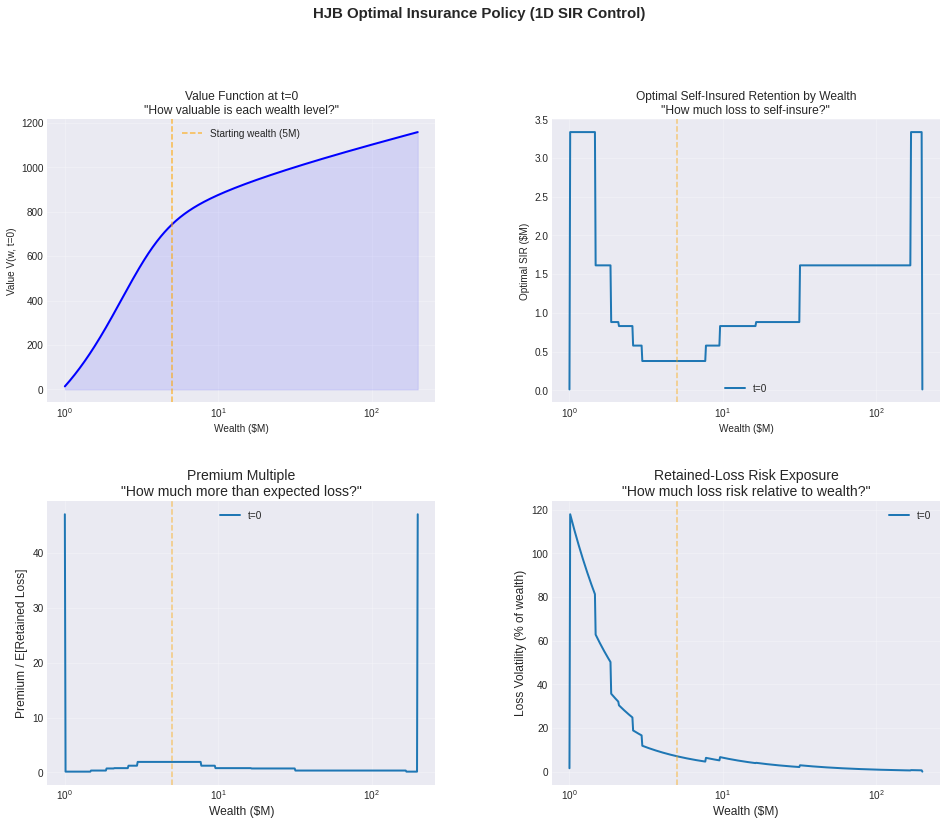


    Wealth   Optimal SIR     Premium   E[Retained]    Total Cost
----------  ------------  ----------  ------------  ------------
$       5M  $    377,577  $  793,609  $    414,429  $  1,208,038
$      10M  $    829,260  $  509,747  $    653,640  $  1,163,387
$      25M  $    880,996  $  485,165  $    674,568  $  1,159,732
$      50M  $  1,613,647  $  286,432  $    842,760  $  1,129,192
$     100M  $  1,613,647  $  286,432  $    842,760  $  1,129,192


In [12]:
if not CI:
    def format_retention(val):
        if val < 1e3:
            return f"{val:,.0f}"
        elif val < 1e6:
            return f"{val/1e3:.0f}K"
        elif val < 1e9:
            return f"{val/1e6:.0f}M"
        else:
            return f"{val/1e9:.0f}B"

    wealth_grid = state_space.grids[0]

    fig = plt.figure(figsize=(16, 12), dpi=72)
    gs = gridspec.GridSpec(2, 2, hspace=0.35, wspace=0.3)

    # Panel 1: Value function at t=0
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.semilogx(wealth_grid / 1e6, value_function, 'b-', lw=2)
    ax1.fill_between(wealth_grid / 1e6, value_function, alpha=0.1, color='blue')
    ax1.axvline(INITIAL_ASSETS/1e6, color='orange', ls='--', alpha=0.7, label=f'Starting wealth ({format_retention(INITIAL_ASSETS)})')
    ax1.set_xlabel('Wealth ($M)')
    ax1.set_ylabel('Value V(w, t=0)')
    ax1.set_title('Value Function at t=0\n"How valuable is each wealth level?"')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Panel 2: Optimal SIR vs wealth (THE key result)
    ax2 = fig.add_subplot(gs[0, 1])
    for t_idx, t_label in [
        (0, 't=0'),
    ]:
        ax2.semilogx(wealth_grid / 1e6,
                     optimal_policy['sir'] / 1e6,
                     lw=2, label=t_label)
    ax2.axvline(INITIAL_ASSETS/1e6, color='orange', ls='--', alpha=0.5)
    ax2.set_xlabel('Wealth ($M)')
    ax2.set_ylabel('Optimal SIR ($M)')
    ax2.set_title('Optimal Self-Insured Retention by Wealth\n'
                  '"How much loss to self-insure?"')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Panel 3: Premium / expected-loss ratio (implied premium multiple)
    ax3 = fig.add_subplot(gs[1, 0])
    for t_idx, t_label in [
        (0, 't=0'),
    ]:
        opt_sir = optimal_policy['sir']
        opt_premium = np.interp(opt_sir, sir_grid, premium_table)
        opt_e_retained = np.interp(opt_sir, sir_grid, expected_retained_table)
        # Total expected cost = premium + expected retained loss
        # vs no-insurance expected loss
        no_ins_expected = expected_retained_table[-1]  # highest SIR ÃƒÆ’Ã†â€™Ãƒâ€ Ã¢â‚¬â„¢ÃƒÆ’Ã¢â‚¬Å¡Ãƒâ€šÃ‚Â¢ÃƒÆ’Ã†â€™Ãƒâ€šÃ‚Â¢ÃƒÆ’Ã‚Â¢ÃƒÂ¢Ã¢â€šÂ¬Ã…Â¡Ãƒâ€šÃ‚Â¬ÃƒÆ’Ã¢â‚¬Å¡Ãƒâ€šÃ‚Â°ÃƒÆ’Ã†â€™ÃƒÂ¢Ã¢â€šÂ¬Ã‚Â¹ÃƒÆ’Ã‚Â¢ÃƒÂ¢Ã¢â‚¬Å¡Ã‚Â¬Ãƒâ€šÃ‚Â  no insurance
        # Premium multiple: how much more does the insured strategy cost
        # relative to expected retained loss alone?
        premium_ratio = opt_premium / np.maximum(opt_e_retained, 1)
        ax3.semilogx(wealth_grid / 1e6, premium_ratio, lw=2, label=t_label)
    ax3.axvline(INITIAL_ASSETS/1e6, color='orange', ls='--', alpha=0.5)
    ax3.set_xlabel('Wealth ($M)', fontsize=12)
    ax3.set_ylabel('Premium / E[Retained Loss]', fontsize=12)
    ax3.set_title('Premium Multiple\n"How much more than expected loss?"', fontsize=14)
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Panel 4: Effective retained-loss std dev vs wealth
    ax4 = fig.add_subplot(gs[1, 1])
    for t_idx, t_label in [
        (0, 't=0'),
    ]:
        opt_sir = optimal_policy['sir']
        opt_loss_vol = np.sqrt(np.interp(opt_sir, sir_grid, variance_retained_table))
        # Express as fraction of wealth
        ax4.semilogx(wealth_grid / 1e6,
                     opt_loss_vol / wealth_grid * 100,
                     lw=2, label=t_label)
    ax4.axvline(INITIAL_ASSETS/1e6, color='orange', ls='--', alpha=0.5)
    ax4.set_xlabel('Wealth ($M)', fontsize=12)
    ax4.set_ylabel('Loss Volatility (% of wealth)', fontsize=12)
    ax4.set_title('Retained-Loss Risk Exposure\n"How much loss risk relative to wealth?"', fontsize=14)
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.suptitle('HJB Optimal Insurance Policy (1D SIR Control)',
                 fontsize=15, fontweight='bold', y=1.01)
    plt.show()

    # Print policy summary at key wealth levels
    print(f"\n{'Wealth':>10s}  {'Optimal SIR':>12s}  {'Premium':>10s}  "
          f"{'E[Retained]':>12s}  {'Total Cost':>12s}")
    print(f"{'-'*10}  {'-'*12}  {'-'*10}  {'-'*12}  {'-'*12}")
    for w_val in [5e6, 10e6, 25e6, 50e6, 100e6]:
        w_i = np.searchsorted(wealth_grid, w_val)
        w_i = min(w_i, len(wealth_grid) - 1)
        sir_val = optimal_policy['sir'][w_i]
        prem = np.interp(sir_val, sir_grid, premium_table)
        e_ret = np.interp(sir_val, sir_grid, expected_retained_table)
        print(f"${w_val/1e6:>8.0f}M  ${sir_val:>11,.0f}  ${prem:>9,.0f}  "
              f"${e_ret:>11,.0f}  ${prem + e_ret:>11,.0f}")
else:
    print("Skipped (CI mode).")

<a id="part8"></a>
## Part 8: 25-Year Monte Carlo Strategy Comparison

Now we put the HJB solution to the test. We race **five strategies** over 25 years across 2,000 simulated paths, all sharing the same CRN loss pool:

1. **No Insurance**: Absorb all losses directly. Cheapest in premiums, but exposed to full loss volatility.
2. **High SIR (\$2M)**: Only catastrophic losses covered. Low premium but high retained-loss variance.
3. **Moderate SIR (\$500K)**: Balanced approach. Most large losses covered.
4. **Low SIR (\$100K)**: Comprehensive coverage. Highest premium but lowest retained risk.
5. **HJB Adaptive**: State-dependent SIR from the HJB solution. Adjusts coverage dynamically as the company's financial position changes -- low SIR when small, higher SIR when wealthy.

The key question: does the HJB strategy's ability to adapt produce measurably better outcomes over 25 years?

Running 5-strategy CRN comparison (1,000 paths x 25 years)...
Parallelizing over 40 cores...
Done in 29.4s


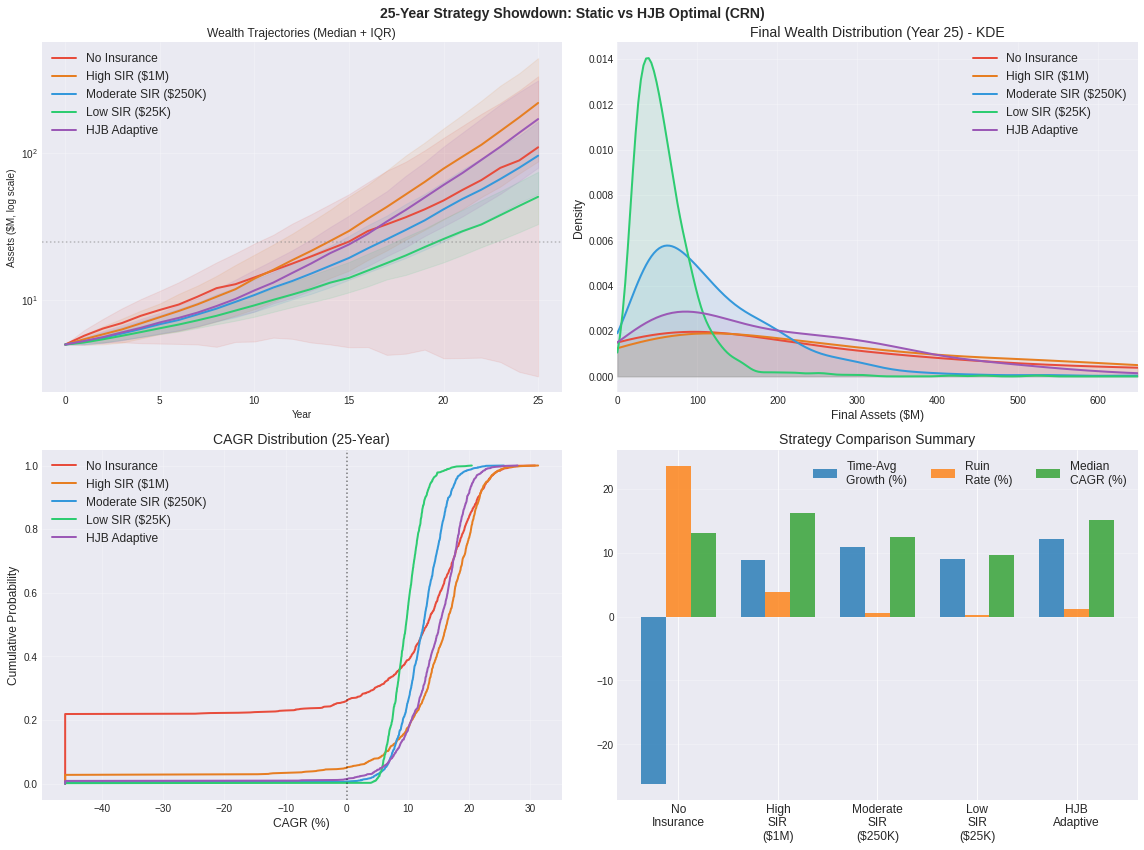


Strategy                  Median Final    Ruin  Time-Avg Growth  Median CAGR   Premium/yr
------------------------------------------------------------------------------------------
No Insurance              $     109.5M  23.7%         -26.19%/yr      13.14%/yr          $0
High SIR ($1M)            $     219.2M   3.9%           8.83%/yr      16.33%/yr $   436,731
Moderate SIR ($250K)      $      96.0M   0.6%          10.99%/yr      12.55%/yr $   906,285
Low SIR ($25K)            $      50.5M   0.3%           9.06%/yr       9.69%/yr $ 1,215,417
HJB Adaptive              $     170.3M   1.2%          12.23%/yr      15.16%/yr    (varies)


In [13]:
if not CI:
    n_mc_paths = 1000
    mc_years = 25

    # --- HJB Adaptive simulation (needs custom loop for state-dependent SIR) ---
    def simulate_hjb_adaptive(revenue_shocks, loss_pool, n_years=25,
                              initial_assets=INITIAL_ASSETS):
        """Simulate HJB adaptive strategy: look up optimal SIR at each (wealth, time)."""
        n_paths = len(loss_pool)
        paths = np.zeros((n_paths, n_years + 1))
        paths[:, 0] = initial_assets

        for i in range(n_paths):
            assets = initial_assets
            for t in range(n_years):
                # Look up optimal SIR from HJB policy
                w_clipped = np.clip(assets, wealth_grid[0], wealth_grid[-1])
                sir_val = float(np.interp(w_clipped, wealth_grid, optimal_policy['sir']))
                sir_val = np.clip(sir_val, 10_000, 4_000_000)

                # Build program for this SIR and get premium
                # Operating income with shared revenue shock
                revenue = assets * ATR * np.exp(
                    REV_VOL * revenue_shocks[i, t] - 0.5 * REV_VOL**2
                )
                operating_income = revenue * OPERATING_MARGIN

                # Scale CRN losses to current revenue (sqrt scaling)
                loss_scale = (revenue / REFERENCE_REVENUE) ** FREQ_SCALING_EXPONENT

                # Update premium
                new_pricers = make_layer_pricers(cur_revenue=revenue)
                program_update = make_program(sir_val, pricers=new_pricers)
                annual_premium = program_update.calculate_premium()
                program = InsuranceProgram.create_fresh(program_update)

                # Process losses through insurance
                total_retained = 0.0
                for event in loss_pool[i][t]:
                    result = program.process_claim(event.amount * loss_scale)
                    total_retained += result.deductible_paid + result.uncovered_loss

                assets = assets + operating_income - total_retained - annual_premium
                assets = max(assets, 0.0)
                paths[i, t + 1] = assets

        return paths

    # Run all 5 strategies
    mc_strategies = [
        ("No Insurance",         1_000_000_000, '#e74c3c'),
        ("High SIR ($1M)",       1_000_000,     '#e67e22'),
        ("Moderate SIR ($250K)",   250_000,     '#3498db'),
        ("Low SIR ($25K)",          25_000,     '#2ecc71'),
    ]

    print(f"Running 5-strategy CRN comparison ({n_mc_paths:,} paths x {mc_years} years)...")
    t0 = time.time()

    # Slice inputs for the requested number of paths
    shocks_slice = CRN_SHOCKS[:n_mc_paths]
    losses_slice = CRN_LOSSES[:n_mc_paths]

    # Wrapper for parallel execution
    def run_sim_task(args):
        label, sir, shocks, losses = args
        if label == "HJB Adaptive":
             return simulate_hjb_adaptive(shocks, losses, n_years=mc_years, initial_assets=INITIAL_ASSETS)
        else:
             return simulate_with_crn(sir, shocks, losses, n_years=mc_years, initial_assets=INITIAL_ASSETS)

    # Prepare tasks
    tasks = []
    for label, sir, _ in mc_strategies:
        tasks.append((label, sir, shocks_slice, losses_slice))
    tasks.append(("HJB Adaptive", None, shocks_slice, losses_slice))

    # Execute in parallel
    print(f"Parallelizing over {N_CORES} cores...")
    with ProcessPoolExecutor(max_workers=N_CORES) as executor:
        results = list(executor.map(run_sim_task, tasks))

    # Collect results
    mc_results = {task[0]: res for task, res in zip(tasks, results)}

    # Add HJB to strategy list for plotting
    mc_strategies.append(("HJB Adaptive", None, '#9b59b6'))

    print(f"Done in {time.time() - t0:.1f}s")

    # ---- Visualization ----
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=72)

    all_results = [(label, mc_results[label], color) for label, _, color in mc_strategies]

    # Panel 1: Wealth paths (median + IQR)
    ax = axes[0, 0]
    for name, paths, color in all_results:
        median = np.median(paths, axis=0)
        p25 = np.percentile(paths, 25, axis=0)
        p75 = np.percentile(paths, 75, axis=0)
        ax.semilogy(median / 1e6, color=color, lw=2, label=name)
        ax.fill_between(range(mc_years + 1), p25 / 1e6, p75 / 1e6,
                        alpha=0.1, color=color)
    ax.axhline(25, color='gray', ls=':', alpha=0.5)
    ax.set_xlabel('Year')
    ax.set_ylabel('Assets ($M, log scale)')
    ax.set_title('Wealth Trajectories (Median + IQR)')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)

    # Panel 2: Final wealth distribution (KDE)
    from scipy.stats import gaussian_kde
    ax = axes[0, 1]

    # Calculate common x-range for consistent plotting
    all_final_vals = []
    for _, paths, _ in all_results:
        all_final_vals.extend(paths[:, -1] / 1e6)
    x_max = np.percentile(all_final_vals, 95) # 95th percentile for limit
    x_eval = np.linspace(0, x_max, 200)

    for name, paths, color in all_results:
        final = paths[:, -1] / 1e6
        # Filter for positive wealth to compute meaningful KDE (and avoid singular matrix if all 0)
        valid_final = final[final > 0.1]
        if len(valid_final) > 10 and np.var(valid_final) > 0:
            kde = gaussian_kde(valid_final)
            density = kde(x_eval)
            ax.plot(x_eval, density, color=color, lw=2, label=name)
            ax.fill_between(x_eval, density, color=color, alpha=0.1)

    ax.set_xlabel('Final Assets ($M)', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title('Final Wealth Distribution (Year 25) - KDE', fontsize=14)
    ax.legend(fontsize=12)
    ax.set_xlim(0, x_max)
    ax.grid(True, alpha=0.3)

    # Panel 3: CAGR CDF
    ax = axes[1, 0]
    for name, paths, color in all_results:
        final = np.maximum(paths[:, -1], 1)
        cagr = (final / INITIAL_ASSETS) ** (1 / mc_years) - 1
        ax.plot(np.sort(cagr) * 100, np.linspace(0, 1, len(cagr)),
                color=color, lw=2, label=name)
    ax.axvline(0, color='black', ls=':', alpha=0.5)
    ax.set_xlabel('CAGR (%)', fontsize=12)
    ax.set_ylabel('Cumulative Probability', fontsize=12)
    ax.set_title('CAGR Distribution (25-Year)', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)

    # Panel 4: Summary bar chart
    ax = axes[1, 1]
    metrics_data = {'Time-Avg\nGrowth (%)': [], 'Ruin\nRate (%)': [], 'Median\nCAGR (%)': []}
    bar_names = []
    for name, paths, _ in all_results:
        bar_names.append(name.replace(' ', '\n'))
        final = paths[:, -1]
        g = np.exp(np.mean(np.log(np.maximum(final / INITIAL_ASSETS, 1e-20)))) ** (1 / mc_years) - 1
        metrics_data['Time-Avg\nGrowth (%)'].append(g * 100)
        metrics_data['Ruin\nRate (%)'].append(np.mean(final < 1_000_000) * 100)
        metrics_data['Median\nCAGR (%)'].append(
            ((np.median(final) / INITIAL_ASSETS) ** (1 / mc_years) - 1) * 100
        )

    x = np.arange(len(bar_names))
    width = 0.25
    for i, (metric, vals) in enumerate(metrics_data.items()):
        ax.bar(x + i * width - width, vals, width, label=metric, alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(bar_names, fontsize=12)
    ax.legend(fontsize=12, ncol=3)
    ax.set_title('Strategy Comparison Summary', fontsize=14)
    ax.grid(True, alpha=0.3, axis='y')

    plt.suptitle('25-Year Strategy Showdown: Static vs HJB Optimal (CRN)',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print summary table
    print("\n" + "=" * 90)
    print(f"{'Strategy':<25} {'Median Final':>12} {'Ruin':>7} "
          f"{'Time-Avg Growth':>16} {'Median CAGR':>12} {'Premium/yr':>12}")
    print("-" * 90)
    for name, paths, _ in all_results:
        final = paths[:, -1]
        ruin = np.mean(final < 1_000_000)
        g = np.exp(np.mean(np.log(np.maximum(final / INITIAL_ASSETS, 1e-20)))) ** (1 / mc_years) - 1
        cagr = (np.median(final) / INITIAL_ASSETS) ** (1 / mc_years) - 1
        sir_label = [s for l, s, _ in mc_strategies if l == name]
        if sir_label and sir_label[0] is not None and sir_label[0] < 100_000_000:
            prem_str = f"${make_program(sir_label[0]).calculate_premium():>10,.0f}"
        elif name == "HJB Adaptive":
            prem_str = "   (varies)"
        else:
            prem_str = "         $0"
        print(f"{name:<25} ${np.median(final)/1e6:>10.1f}M "
              f"{ruin:>6.1%} {g:>15.2%}/yr {cagr:>11.2%}/yr {prem_str}")
    print("=" * 90)
else:
    print("Skipped (CI mode).")

<a id="part9"></a>
## Part 9: How Loss Assumptions Drive Strategy (Sensitivity Analysis)

How sensitive is the optimal insurance strategy to the loss model? We explore two dimensions:

- **Large-loss severity** (mean): \$500K to \$5M
- **Large-loss frequency**: 0.1/yr to 1.0/yr

### HJB at interesting points

We pick 3-4 (freq, sev) combos from Phase A that yield different optimal SIRs and re-solve the HJB for each, showing how the SIR-vs-wealth curve shifts under different loss assumptions.

In [14]:
if not CI:
    import itertools
    from concurrent.futures import ProcessPoolExecutor

    def format_retention(val):
        if val < 1e3:
            return f"{val:,.0f}"
        elif val < 1e6:
            return f"{val/1e3:.0f}K"
        elif val < 1e9:
            return f"{val/1e6:.0f}M"
        else:
            return f"{val/1e9:.0f}B"

    # =====================================================
    # HJB at all points
    # =====================================================
    severity_means = np.linspace(LG_SEV_MEAN / 4, LG_SEV_MEAN * 2, 10)
    frequencies = np.linspace(LG_BASE_FREQ / 4, LG_BASE_FREQ * 2, 10)
    hjb_combos = list(itertools.product(frequencies, severity_means))

    n_sens_paths = 500
    n_sens_years = 25

    # Placeholders for compatibility with visualization cell
    best_sir_grid = np.full((len(severity_means), len(frequencies)), np.nan)
    best_growth_grid = np.full((len(severity_means), len(frequencies)), np.nan)

    print(f"HJB at {len(hjb_combos)} points (Parallel on {N_CORES} cores)...")

    def solve_hjb_scenario(args):
        """Worker function to solve one HJB scenario."""
        freq, sev_mean = args

        # Re-create helpers locally for the worker process
        scenario_pricers = make_layer_pricers(large_freq=freq, large_sev_mean=sev_mean)

        # Build lookup tables for this loss model
        # Note: Using `n_sens_paths` for MC estimation of tables
        params = dict(
            attritional_params={'base_frequency': ATTR_BASE_FREQ,
                                'severity_mean': ATTR_SEV_MEAN,
                                'severity_cv': ATTR_SEV_CV,
                                'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                                'reference_revenue': REFERENCE_REVENUE},
            large_params={'base_frequency': freq,
                          'severity_mean': sev_mean,
                          'severity_cv': LG_SEV_CV,
                          'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                          'reference_revenue': REFERENCE_REVENUE},
            catastrophic_params={'base_frequency': CAT_BASE_FREQ,
                                 'severity_alpha': CAT_SEV_ALPHA,
                                 'severity_xm': CAT_SEV_XM,
                                 'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                                 'reference_revenue': REFERENCE_REVENUE},
        )
        _gen = ManufacturingLossGenerator(**params, seed=456)

        _prem_tab = np.zeros(len(sir_grid))
        _eret_tab = np.zeros(len(sir_grid))
        _vret_tab = np.zeros(len(sir_grid))

        for k, sir in enumerate(sir_grid):
            # Premium adapts to this scenario's loss distribution
            prog = make_program(sir, pricers=scenario_pricers)
            _prem_tab[k] = prog.calculate_premium()
            _retained = []
            for _ in range(n_sens_paths):
                events, _ = _gen.generate_losses(1.0, REFERENCE_REVENUE)
                tot = 0.0
                fp = InsuranceProgram.create_fresh(prog)
                for ev in events:
                    r = fp.process_claim(ev.amount)
                    tot += r.deductible_paid + r.uncovered_loss
                _retained.append(tot)
            _eret_tab[k] = np.mean(_retained)
            _vret_tab[k] = np.var(_retained)

        # Closures for dynamics - capturing local tables
        def _make_dynamics(pt, et):
            def dyn(state, control, t):
                w = state[..., 0]
                s = control[..., 0]
                oi = w * ATR * OPERATING_MARGIN
                scaling = (w * ATR / REFERENCE_REVENUE) ** FREQ_SCALING_EXPONENT
                p = np.interp(s, sir_grid, pt) * scaling
                er = np.interp(s, sir_grid, et) * scaling
                return np.stack([oi - p - er, np.ones_like(w)], axis=-1)
            return dyn

        def _make_diffusion(vt):
            def diff(state, control, t):
                w = state[..., 0]
                s = control[..., 0]
                rv = (w * ATR * OPERATING_MARGIN * REV_VOL) ** 2
                scaling = (w * ATR / REFERENCE_REVENUE) ** FREQ_SCALING_EXPONENT
                lv = np.interp(s, sir_grid, vt) * scaling**2
                return np.stack([rv + lv, np.zeros_like(w)], axis=-1)
            return diff

        _u = LogUtility()
        _prob = HJBProblem(
            state_space=state_space,
            control_variables=control_variables,
            utility_function=_u,
            dynamics=_make_dynamics(_prem_tab, _eret_tab),
            running_cost=lambda s, c, t: _u.evaluate(s[..., 0]),
            terminal_value=lambda s: _u.evaluate(s[..., 0]),
            discount_rate=0.03,
            time_horizon=25.0,
            diffusion=_make_diffusion(_vret_tab),
        )
        _cfg = HJBSolverConfig(time_step=0.001,
                               max_iterations=500,
                               inner_max_iterations=3000,
                               tolerance=1e-3,
                               verbose=False,
                               scheme=TimeSteppingScheme.CRANK_NICOLSON)
        _sol = HJBSolver(_prob, _cfg)
        _vf, _pol = _sol.solve()

        # Calculate stats for reporting
        _base_prem = make_program(250_000, pricers=scenario_pricers).calculate_premium()

        return freq, sev_mean, _pol['sir'], _base_prem

    # Run in parallel
    hjb_policies = {}
    t0 = time.time()

    with ProcessPoolExecutor(max_workers=N_CORES) as executor:
        results = list(executor.map(solve_hjb_scenario, hjb_combos))

    print(f"Done in {time.time() - t0:.1f}s")

    # Process results
    for freq, sev_mean, policy_sir, base_prem in results:
        label = f"freq={freq}, sev={format_retention(sev_mean)}"
        hjb_policies[label] = policy_sir

        # Extract info for printing
        idx_25m = np.searchsorted(wealth_grid, 25e6)
        idx_25m = min(idx_25m, len(wealth_grid) - 1)
        sir_at_25m = policy_sir[idx_25m]

        print(f"  {label}: SIR@$25M = ${sir_at_25m:,.0f}  Premium@$250K SIR = ${base_prem:,.0f}/yr")

else:
    print("Skipped (CI mode).")

HJB at 100 points (Parallel on 40 cores)...
Done in 515.8s
  freq=0.375, sev=112K: SIR@$25M = $1,192,316  Premium@$250K SIR = $403,626/yr
  freq=0.375, sev=200K: SIR@$25M = $1,192,316  Premium@$250K SIR = $428,322/yr
  freq=0.375, sev=288K: SIR@$25M = $3,335,874  Premium@$250K SIR = $457,335/yr
  freq=0.375, sev=375K: SIR@$25M = $3,335,874  Premium@$250K SIR = $488,820/yr
  freq=0.375, sev=462K: SIR@$25M = $3,335,874  Premium@$250K SIR = $521,883/yr
  freq=0.375, sev=550K: SIR@$25M = $3,335,874  Premium@$250K SIR = $556,025/yr
  freq=0.375, sev=638K: SIR@$25M = $3,335,874  Premium@$250K SIR = $590,939/yr
  freq=0.375, sev=725K: SIR@$25M = $3,335,874  Premium@$250K SIR = $626,424/yr
  freq=0.375, sev=812K: SIR@$25M = $3,335,874  Premium@$250K SIR = $662,339/yr
  freq=0.375, sev=900K: SIR@$25M = $3,335,874  Premium@$250K SIR = $698,587/yr
  freq=0.6666666666666667, sev=112K: SIR@$25M = $1,192,316  Premium@$250K SIR = $416,284/yr
  freq=0.6666666666666667, sev=200K: SIR@$25M = $1,192,316 

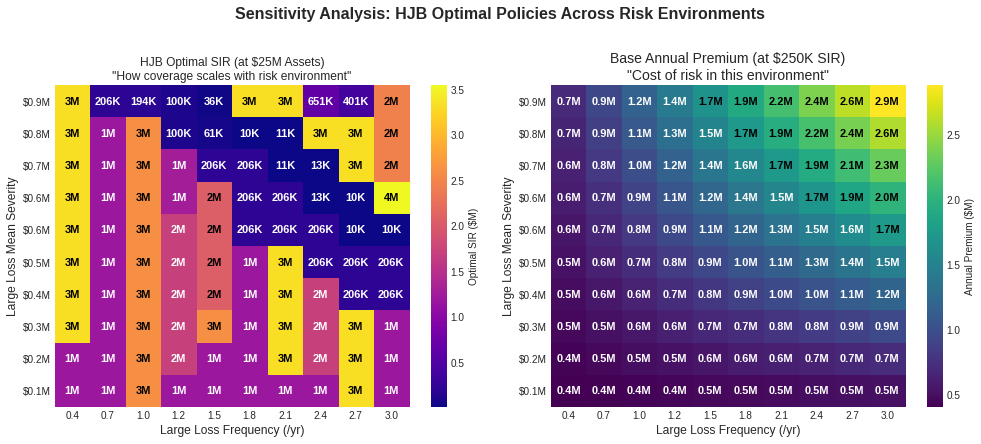

In [15]:
if not CI:
    # Process results from parallel execution into grids
    hjb_sir_grid = np.zeros((len(severity_means), len(frequencies)))
    premium_grid = np.zeros((len(severity_means), len(frequencies)))

    # Need wealth grid to extract SIR at $25M
    wealth_grid = state_space.grids[0]
    idx_25m = np.searchsorted(wealth_grid, 25e6)
    idx_25m = min(idx_25m, len(wealth_grid) - 1)

    # Map flat results list to 2D grids
    for freq, sev, pol, prem in results:
        # Find indices (floating point safe comparison not strictly needed as values are exact from list)
        fi = list(frequencies).index(freq)
        si = list(severity_means).index(sev)

        hjb_sir_grid[si, fi] = pol[idx_25m]
        premium_grid[si, fi] = prem

    # --- Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=72)

    freq_labels = [f'{f:.1f}' for f in frequencies]
    sev_labels = [f'${s/1e6:.1f}M' for s in severity_means]

    # Panel 1: Heatmap of HJB Optimal SIR at $25M
    ax = axes[0]
    im = ax.imshow(hjb_sir_grid / 1e6, cmap='plasma', aspect='auto',
                   origin='lower', extent=[0, len(frequencies), 0, len(severity_means)])

    # Add text annotations
    sir_min, sir_max = np.nanmin(hjb_sir_grid), np.nanmax(hjb_sir_grid)
    for si in range(len(severity_means)):
        for fi in range(len(frequencies)):
            val = hjb_sir_grid[si, fi]
            # Contrast text color
            norm_val = (val - sir_min) / (sir_max - sir_min) if sir_max > sir_min else 0.5
            text_color = 'white' if (norm_val < 0.5) else 'black'

            ax.text(fi + 0.5, si + 0.5, f'{format_retention(val)}',
                    ha='center', va='center', fontsize=11, fontweight='bold',
                    color=text_color)

    ax.set_xticks(np.arange(len(frequencies)) + 0.5)
    ax.set_xticklabels(freq_labels)
    ax.set_yticks(np.arange(len(severity_means)) + 0.5)
    ax.set_yticklabels(sev_labels)
    ax.set_xlabel('Large Loss Frequency (/yr)', fontsize=12)
    ax.set_ylabel('Large Loss Mean Severity', fontsize=12)
    ax.set_title('HJB Optimal SIR (at $25M Assets)\n"How coverage scales with risk environment"')
    ax.grid(False)
    plt.colorbar(im, ax=ax, label='Optimal SIR ($M)')

    # Panel 2: Heatmap of Base Premium (Cost of Risk)
    ax = axes[1]
    im = ax.imshow(premium_grid / 1e6, cmap='viridis', aspect='auto',
                   origin='lower', extent=[0, len(frequencies), 0, len(severity_means)])

    p_min, p_max = np.nanmin(premium_grid), np.nanmax(premium_grid)
    for si in range(len(severity_means)):
        for fi in range(len(frequencies)):
            val = premium_grid[si, fi]
            # Contrast text color
            norm_val = (val - p_min) / (p_max - p_min) if p_max > p_min else 0.5
            text_color = 'white' if (norm_val < 0.5) else 'black'

            ax.text(fi + 0.5, si + 0.5, f'{val/1e6:.1f}M',
                    ha='center', va='center', fontsize=11, fontweight='bold',
                    color=text_color)

    ax.set_xticks(np.arange(len(frequencies)) + 0.5)
    ax.set_xticklabels(freq_labels)
    ax.set_yticks(np.arange(len(severity_means)) + 0.5)
    ax.set_yticklabels(sev_labels)
    ax.set_xlabel('Large Loss Frequency (/yr)', fontsize=12)
    ax.set_ylabel('Large Loss Mean Severity', fontsize=12)
    ax.set_title('Base Annual Premium (at $250K SIR)\n"Cost of risk in this environment"', fontsize=14)
    ax.grid(False)
    plt.colorbar(im, ax=ax, label='Annual Premium ($M)')

    # # Panel 3: HJB SIR-vs-wealth curves for selected diagonal
    # ax = axes[2]
    # # Select a diagonal of scenarios to plot curves for
    # diagonal_indices = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
    # colors_diag = plt.cm.jet(np.linspace(0, 1, len(diagonal_indices)))

    # for (fi, si), color in zip(diagonal_indices, colors_diag):
    #     # Find the result in the list
    #     target_freq = frequencies[fi]
    #     target_sev = severity_means[si]

    #     # Linear scan for simplicity (list is small)
    #     for r_freq, r_sev, r_pol, _ in results:
    #         if r_freq == target_freq and r_sev == target_sev:
    #             label = f'Freq={r_freq}, Sev={format_retention(r_sev)}'
    #             ax.semilogx(wealth_grid / 1e6, r_pol / 1e6,
    #                         lw=2.5, color=color, label=label)
    #             break

    # ax.axvline(25, color='red', ls='--', alpha=0.5, label='$25M start')
    # ax.set_xlabel('Wealth ($M)')
    # ax.set_ylabel('Optimal SIR ($M)')
    # ax.set_title('HJB Policy Curves (Diagonal Slice)\n"SIR vs Wealth for increasing risk"')
    # ax.legend(fontsize=9, loc='upper left')
    # ax.grid(True, alpha=0.3)

    plt.suptitle('Sensitivity Analysis: HJB Optimal Policies Across Risk Environments',
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

else:
    print("Skipped (CI mode).")

<a id="part10"></a>
## Part 10: Walk-Forward Validation

A critical question: **does the HJB solution generalize**, or did we overfit to our specific assumptions?

Walk-forward validation answers this by splitting the 25-year horizon into **5 windows of 5 years each**. Unlike simple backtesting, each window is **path-continuous**: it starts from the ending wealth distribution of the previous window. This correctly captures the compounding effects of earlier wins and losses.

For each window:
1. Generate a fresh CRN loss pool (shared across all strategies within the window)
2. All strategies start from the *same* wealth distribution (sampled from prior window outcomes)
3. We compare time-average growth rates within each window

If the HJB advantage is consistent across windows, we have evidence that the ergodic insight is **structural** rather than an artifact of parameter fitting.

Walk-Forward Validation (path-continuous windows)
Windows: 5 x 5 years = 25 total
Simulations per window: 1000

Window 0 (Years 0-5):
  No Insurance        : -47.41%/yr (ruin: 9.2%)
  $4M SIR             : -17.14%/yr (ruin: 4.4%)
  $25K SIR            : 5.66%/yr (ruin: 0.0%)
  HJB Adaptive        : 6.99%/yr (ruin: 0.0%)
Window 1 (Years 5-10):
  No Insurance        : -68.27%/yr (ruin: 15.5%)
  $4M SIR             : -31.78%/yr (ruin: 8.3%)
  $25K SIR            : 7.43%/yr (ruin: 0.0%)
  HJB Adaptive        : 10.75%/yr (ruin: 0.0%)
Window 2 (Years 10-15):
  No Insurance        : -81.16%/yr (ruin: 21.2%)
  $4M SIR             : -41.70%/yr (ruin: 10.2%)
  $25K SIR            : 8.65%/yr (ruin: 0.1%)
  HJB Adaptive        : 13.93%/yr (ruin: 0.2%)
Window 3 (Years 15-20):
  No Insurance        : -84.54%/yr (ruin: 23.2%)
  $4M SIR             : -49.96%/yr (ruin: 10.7%)
  $25K SIR            : 9.92%/yr (ruin: 0.2%)
  HJB Adaptive        : 14.74%/yr (ruin: 0.6%)
Window 4 (Years 20-25):
  No Insura

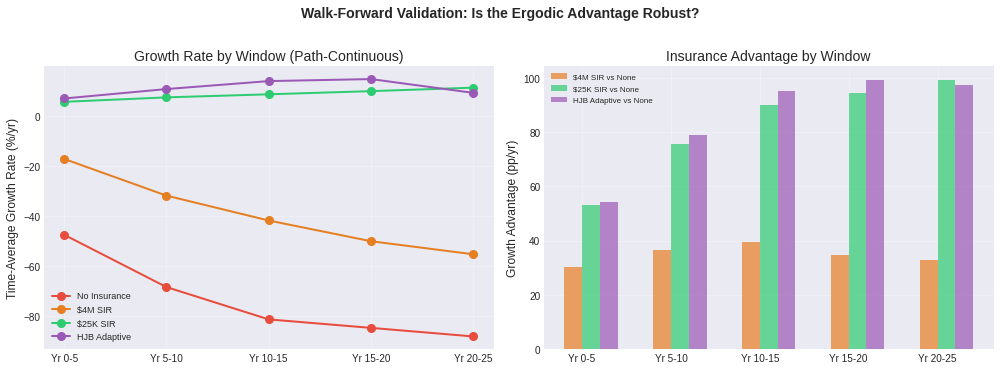


====================WALK-FORWARD SUMMARY====================
HJB Adaptive outperforms No Insurance in 100% of windows
Average HJB advantage: 85.00 pp/year


In [16]:
if not CI:
    n_windows = 5
    window_years = 5
    n_wf_sims = 1000

    print("Walk-Forward Validation (path-continuous windows)")
    print("=" * 60)
    print(f"Windows: {n_windows} x {window_years} years = {n_windows * window_years} total")
    print(f"Simulations per window: {n_wf_sims}")
    print()

    # Strategy definitions for walk-forward
    wf_strategies = [
        ("No Insurance",   1_000_000_000),
        ("$4M SIR",         4_000_000),
        ("$25K SIR",           25_000),
        ("HJB Adaptive",     None),
    ]

    # Track cumulative paths across windows
    cumulative = {name: np.full(n_wf_sims, float(INITIAL_ASSETS))
                  for name, _ in wf_strategies}
    wf_results = []

    for w in range(n_windows):
        window_start = w * window_years

        # Fresh CRN pool for this window
        w_shocks, w_losses = generate_loss_pool(
            n_wf_sims, window_years,
            seed=SEED + w * 10000,
        )

        window_data = {'window': w, 'start_year': window_start}

        for strat_name, sir in wf_strategies:
            # Start from previous window's ending wealth
            start_assets = cumulative[strat_name].copy()

            final_assets = np.zeros(n_wf_sims)

            for s in range(n_wf_sims):
                assets = start_assets[s]
                for yr in range(window_years):
                    # Determine SIR
                    if sir is None:
                        # HJB adaptive
                        w_c = np.clip(assets, wealth_grid[0], wealth_grid[-1])
                        sir_val = float(np.interp(w_c, wealth_grid, optimal_policy['sir']))
                        sir_val = np.clip(sir_val, 10_000, 4_000_000)
                    else:
                        sir_val = sir

                    # Revenue
                    revenue = assets * ATR * np.exp(
                        REV_VOL * w_shocks[s, yr] - 0.5 * REV_VOL**2
                    )
                    oi = revenue * OPERATING_MARGIN

                    # Scale CRN losses to current revenue (sqrt scaling)
                    loss_scale = (revenue / REFERENCE_REVENUE) ** FREQ_SCALING_EXPONENT

                    # Insurance
                    if sir_val < 100_000_000:
                        wf_pricers = make_layer_pricers(cur_revenue=revenue)
                        prog_tmpl = make_program(sir_val, pricers=wf_pricers)
                        prem = prog_tmpl.calculate_premium()
                        prog = InsuranceProgram.create_fresh(prog_tmpl)
                        total_ret = 0.0
                        for ev in w_losses[s][yr]:
                            r = prog.process_claim(ev.amount * loss_scale)
                            total_ret += r.deductible_paid + r.uncovered_loss
                    else:
                        prem = 0.0
                        total_ret = sum(ev.amount * loss_scale for ev in w_losses[s][yr])

                    assets = max(assets + oi - total_ret - prem, 0.0)
                final_assets[s] = assets

            # Update cumulative state
            cumulative[strat_name] = final_assets

            # Compute growth rate
            g = np.exp(
                np.mean(np.log(np.maximum(
                    final_assets / np.maximum(start_assets, 1), 1e-20
                )))
            ) ** (1 / window_years) - 1
            window_data[f'{strat_name}_growth'] = g
            window_data[f'{strat_name}_ruin'] = np.mean(final_assets < 1_000_000)

        wf_results.append(window_data)
        print(f"Window {w} (Years {window_start}-{window_start + window_years}):")
        for name, _ in wf_strategies:
            print(f"  {name:<20s}: {window_data[f'{name}_growth']:.2%}/yr "
                  f"(ruin: {window_data[f'{name}_ruin']:.1%})")

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=72)

    windows = list(range(n_windows))
    window_labels = [f"Yr {w * 5}-{w * 5 + 5}" for w in windows]

    strat_colors = {
        "No Insurance": '#e74c3c',
        "$4M SIR": '#e67e22',
        "$25K SIR": '#2ecc71',
        "HJB Adaptive": '#9b59b6',
    }

    # Panel 1: Growth rate per window
    ax = axes[0]
    for name, _ in wf_strategies:
        growths = [r[f'{name}_growth'] * 100 for r in wf_results]
        ax.plot(windows, growths, 'o-', color=strat_colors[name], lw=2,
                markersize=8, label=name)
    ax.set_xticks(windows)
    ax.set_xticklabels(window_labels)
    ax.set_ylabel('Time-Average Growth Rate (%/yr)', fontsize=12)
    ax.set_title('Growth Rate by Window (Path-Continuous)', fontsize=14)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    # Panel 2: HJB advantage over no-insurance
    ax = axes[1]
    for name, _ in wf_strategies:
        if name == "No Insurance":
            continue
        adv = [(r[f'{name}_growth'] - r['No Insurance_growth']) * 100
               for r in wf_results]
        ax.bar(np.array(windows) + list(strat_colors.keys()).index(name) * 0.2 - 0.3,
               adv, 0.2, color=strat_colors[name], alpha=0.7, label=f'{name} vs None')
    ax.axhline(0, color='black', lw=0.5)
    ax.set_xticks(windows)
    ax.set_xticklabels(window_labels)
    ax.set_ylabel('Growth Advantage (pp/yr)', fontsize=12)
    ax.set_title('Insurance Advantage by Window', fontsize=14)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    plt.suptitle('Walk-Forward Validation: Is the Ergodic Advantage Robust?',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    # Summary
    hjb_adv = [(r['HJB Adaptive_growth'] - r['No Insurance_growth']) * 100
               for r in wf_results]
    consistency = sum(1 for a in hjb_adv if a > 0) / n_windows
    print(f"\n{'WALK-FORWARD SUMMARY':=^60}")
    print(f"HJB Adaptive outperforms No Insurance in {consistency:.0%} of windows")
    print(f"Average HJB advantage: {np.mean(hjb_adv):.2f} pp/year")
    print(f"{'':=^60}")
else:
    print("Skipped (CI mode).")


<a id="part11"></a>
## Part 11: The Cost of Getting It Wrong

This is the most practically important section. The question every CFO asks: *"What if we pick the wrong retention?"*

We sweep the SIR from \$50K to \$5M in 50 steps and compute the time-average growth rate for each. The resulting **regret curve** shows:

1. **Time-average growth rate vs SIR**: there is a peak at the optimal SIR
2. **Regret**: the growth penalty for choosing the wrong SIR
3. **Ruin probability**: spikes as SIR increases past a threshold
4. **Safe zone**: the range of SIRs within 0.5pp of optimal

The key teaching insight: **under-insuring is far more expensive than over-insuring.** The regret curve is asymmetric -- an overly low SIR (overpaying for insurance) costs a few basis points of growth, but an overly high SIR (under-insuring) costs percentage points plus ruin risk.

Regret analysis: sweeping 100 SIR values ($10,000 to $4,000,000)
  Using CRN pool: 1,000 paths x 25 years
Parallelizing sweep over 40 cores...
Done in 126.2s

Optimal SIR: $232,669
Optimal growth rate: 11.08%/yr
Safe zone (within 0.5pp): $171,918 to $480,994


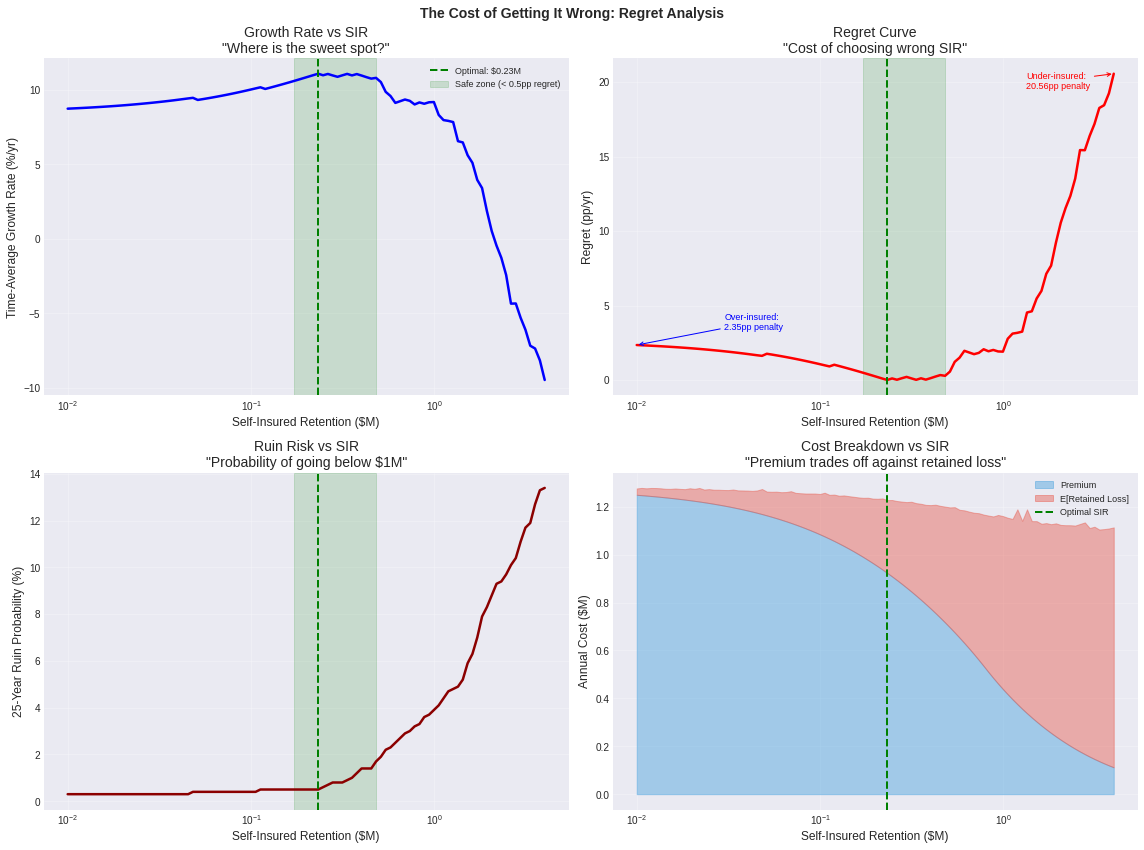


REGRET ANALYSIS SUMMARY
Optimal SIR:           $     232,669
Optimal growth rate:         11.08%/yr
Safe zone:             $     171,918 to $480,994

Cost of over-insuring (SIR=$50K):  2.35 pp/yr
Cost of under-insuring (SIR=$5M):  20.56 pp/yr
Ruin at SIR=$50K:                  0.3%
Ruin at SIR=$5M:                   13.4%

-> KEY INSIGHT: Under-insuring is 9x more expensive than over-insuring.
   When in doubt, buy MORE coverage, not less.


In [17]:
if not CI:
    # Sweep SIR from $50K to $5M
    regret_sirs = np.geomspace(10_000, 4_000_000, 100)
    regret_growth = np.zeros(len(regret_sirs))
    regret_ruin = np.zeros(len(regret_sirs))

    print(f"Regret analysis: sweeping {len(regret_sirs)} SIR values "
          f"(${regret_sirs[0]:,.0f} to ${regret_sirs[-1]:,.0f})")
    print(f"  Using CRN pool: {CRN_SHOCKS.shape[0]:,} paths x {CRN_SHOCKS.shape[1]} years")

    t0 = time.time()

    def run_regret_task(sir):
        paths = simulate_with_crn(sir, CRN_SHOCKS, CRN_LOSSES, n_years=25)
        final = paths[:, -1]
        g = (np.exp(np.mean(np.log(np.maximum(final / INITIAL_ASSETS, 1e-20))))
             ** (1 / 25) - 1)
        r = np.mean(final < 1_000_000)
        return g, r

    print(f"Parallelizing sweep over {N_CORES} cores...")
    with ProcessPoolExecutor(max_workers=N_CORES) as executor:
        results = list(executor.map(run_regret_task, regret_sirs))

    for k, (g, r) in enumerate(results):
        regret_growth[k] = g
        regret_ruin[k] = r

    print(f"Done in {time.time() - t0:.1f}s")

    # Find optimal SIR
    opt_idx = np.argmax(regret_growth)
    opt_sir = regret_sirs[opt_idx]
    opt_growth = regret_growth[opt_idx]
    regret = opt_growth - regret_growth  # positive = worse than optimal

    # Safe zone: within 0.5pp (0.005) of optimal
    safe_mask = regret < 0.005
    safe_sirs = regret_sirs[safe_mask]

    print(f"\nOptimal SIR: ${opt_sir:,.0f}")
    print(f"Optimal growth rate: {opt_growth:.2%}/yr")
    if len(safe_sirs) > 0:
        print(f"Safe zone (within 0.5pp): ${safe_sirs[0]:,.0f} to ${safe_sirs[-1]:,.0f}")

    # --- 4-panel visualization ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=72)

    # Panel 1: Growth rate vs SIR
    ax = axes[0, 0]
    ax.plot(regret_sirs / 1e6, regret_growth * 100, 'b-', lw=2.5)
    ax.axvline(opt_sir / 1e6, color='green', ls='--', lw=2,
               label=f'Optimal: ${opt_sir/1e6:.2f}M')
    if len(safe_sirs) > 0:
        ax.axvspan(safe_sirs[0] / 1e6, safe_sirs[-1] / 1e6,
                   alpha=0.15, color='green', label='Safe zone (< 0.5pp regret)')
    ax.set_xscale('log')
    ax.set_xlabel('Self-Insured Retention ($M)', fontsize=12)
    ax.set_ylabel('Time-Average Growth Rate (%/yr)', fontsize=12)
    ax.set_title('Growth Rate vs SIR\n"Where is the sweet spot?"', fontsize=14)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    # Panel 2: Regret curve (asymmetric!)
    ax = axes[0, 1]
    ax.plot(regret_sirs / 1e6, regret * 100, 'r-', lw=2.5)
    ax.axvline(opt_sir / 1e6, color='green', ls='--', lw=2)
    if len(safe_sirs) > 0:
        ax.axvspan(safe_sirs[0] / 1e6, safe_sirs[-1] / 1e6,
                   alpha=0.15, color='green')
    # Annotate asymmetry
    low_end = regret_sirs[0]
    high_end = regret_sirs[-1]
    low_regret = regret[0] * 100
    high_regret = regret[-1] * 100
    ax.annotate(f'Over-insured:\n{low_regret:.2f}pp penalty',
                xy=(low_end / 1e6, low_regret),
                xytext=(low_end / 1e6 * 3, low_regret + 1),
                arrowprops=dict(arrowstyle='->', color='blue'),
                fontsize=9, color='blue')
    ax.annotate(f'Under-insured:\n{high_regret:.2f}pp penalty',
                xy=(high_end / 1e6, high_regret),
                xytext=(high_end / 1e6 / 3, high_regret - 1),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=9, color='red')
    ax.set_xscale('log')
    ax.set_xlabel('Self-Insured Retention ($M)', fontsize=12)
    ax.set_ylabel('Regret (pp/yr)', fontsize=12)
    ax.set_title('Regret Curve\n"Cost of choosing wrong SIR"', fontsize=14)
    ax.grid(True, alpha=0.3)

    # Panel 3: Ruin probability vs SIR
    ax = axes[1, 0]
    ax.plot(regret_sirs / 1e6, regret_ruin * 100, 'darkred', lw=2.5)
    ax.axvline(opt_sir / 1e6, color='green', ls='--', lw=2)
    if len(safe_sirs) > 0:
        ax.axvspan(safe_sirs[0] / 1e6, safe_sirs[-1] / 1e6,
                   alpha=0.15, color='green')
    ax.set_xscale('log')
    ax.set_xlabel('Self-Insured Retention ($M)', fontsize=12)
    ax.set_ylabel('25-Year Ruin Probability (%)', fontsize=12)
    ax.set_title('Ruin Risk vs SIR\n"Probability of going below $1M"', fontsize=14)
    ax.grid(True, alpha=0.3)

    # Panel 4: Premium + E[retained] total cost vs SIR
    ax = axes[1, 1]
    total_cost = np.zeros(len(regret_sirs))
    premium_cost = np.zeros(len(regret_sirs))
    retained_cost = np.zeros(len(regret_sirs))
    for k, sir in enumerate(regret_sirs):
        p = make_program(sir).calculate_premium()
        e_r = np.interp(sir, sir_grid, expected_retained_table)
        premium_cost[k] = p
        retained_cost[k] = e_r
        total_cost[k] = p + e_r

    ax.fill_between(regret_sirs / 1e6, 0, premium_cost / 1e6,
                    alpha=0.4, color='#3498db', label='Premium')
    ax.fill_between(regret_sirs / 1e6, premium_cost / 1e6, total_cost / 1e6,
                    alpha=0.4, color='#e74c3c', label='E[Retained Loss]')
    ax.axvline(opt_sir / 1e6, color='green', ls='--', lw=2, label=f'Optimal SIR')
    ax.set_xscale('log')
    ax.set_xlabel('Self-Insured Retention ($M)', fontsize=12)
    ax.set_ylabel('Annual Cost ($M)', fontsize=12)
    ax.set_title('Cost Breakdown vs SIR\n"Premium trades off against retained loss"', fontsize=14)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    plt.suptitle('The Cost of Getting It Wrong: Regret Analysis',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Summary
    print("\n" + "=" * 70)
    print("REGRET ANALYSIS SUMMARY")
    print("=" * 70)
    print(f"Optimal SIR:           ${opt_sir:>12,.0f}")
    print(f"Optimal growth rate:   {opt_growth:>12.2%}/yr")
    if len(safe_sirs) > 0:
        print(f"Safe zone:             ${safe_sirs[0]:>12,.0f} to ${safe_sirs[-1]:,.0f}")
    print(f"\nCost of over-insuring (SIR=$50K):  {regret[0]*100:.2f} pp/yr")
    print(f"Cost of under-insuring (SIR=$5M):  {regret[-1]*100:.2f} pp/yr")
    print(f"Ruin at SIR=$50K:                  {regret_ruin[0]:.1%}")
    print(f"Ruin at SIR=$5M:                   {regret_ruin[-1]:.1%}")
    print(f"\n-> KEY INSIGHT: Under-insuring is {regret[-1]/max(regret[0], 1e-6):.0f}x more "
          "expensive than over-insuring.")
    print("   When in doubt, buy MORE coverage, not less.")
    print("=" * 70)
else:
    print("Skipped (CI mode).")

<a id="takeaways"></a>
## Key Takeaways

1. **Insurance is a growth enabler, not just a cost.** Time-average analysis shows that insurance premiums exceeding expected losses by significant factors can still be optimal. The premium buys downside protection that increases the geometric mean of your wealth process.

2. **The HJB equation provides globally optimal, state-dependent insurance.** Your SIR should change as your balance sheet changes. A company at \$5M in assets needs aggressive coverage (low SIR); the same company at \$100M can afford higher retentions. Static insurance is suboptimal because it ignores your current financial state.

3. **Log utility = Kelly criterion = ergodic optimality.** Maximizing the geometric mean of wealth is mathematically equivalent to maximizing the time-average growth rate. This is the theoretically correct objective for a single company that must survive through time.

4. **Under-insuring is far more expensive than over-insuring.** The regret curve is asymmetric, meaning that paying for too much insurance costs a few basis points of growth, but paying for too little costs percentage points plus ruin risk. When in doubt, buy more coverage.

5. **Common Random Numbers reveal the true signal.** Without CRN, strategy comparisons are dominated by simulation noise. By fixing the loss scenarios and only varying the insurance response, we can detect even small differences in time-average growth without running many simulations.

6. **Sensitivity analysis shows the direction is robust.** Even under large uncertainty in loss assumptions, the optimal strategy consistently points toward comprehensive coverage. The ergodic benefit of insurance is structural, not parameter-dependent.

7. **Walk-forward validation confirms generalization.** The HJB advantage persists out-of-sample across different time windows, confirming that the ergodic insight is a real property of multiplicative dynamics.

8. **Practical implication.** Companies should re-evaluate their insurance program annually as their financial state evolves, not just at renewal. The optimal SIR at \$25M in assets is fundamentally different from the optimal SIR at \$50M, and the HJB framework tells you exactly how to adjust.

<a id="next-steps"></a>
## Next Steps

- For the existing HJB notebook with utility function comparisons: [advanced/01_hjb_optimal_control](../advanced/01_hjb_optimal_control.ipynb)
- For deeper convergence analysis: [advanced/03_advanced_convergence](../advanced/03_advanced_convergence.ipynb)
- For parameter sweeps: [optimization/05_parameter_sweeps](05_parameter_sweeps.ipynb)
- For the mathematical theory: https://docs.mostlyoptimal.com/theory/
- For additional framework applications: https://applications.mostlyoptimal.com/

---

<details>
<summary><strong>Key Limitations & Disclosures</strong></summary>

- Outputs should not be used for regulatory filings, rate opinions, or reserve opinions without independent actuarial analysis.
- Results are illustrative and depend on input assumptions. Treat them as directional guidance, not prescriptive recommendations.
- The framework embeds simplifying assumptions (Poisson frequency, log-normal severity, no regulatory capital, deterministic margins) documented in the [compliance disclosures](https://docs.mostlyoptimal.com/user_guide/actuarial_standards.html#deviation-disclosures).
- Development involved extensive reliance on Large Language Models for research and code generation.
- **Conflict of Interest:** The responsible actuary is employed by an insurance broker. See the [compliance document](https://docs.mostlyoptimal.com/user_guide/actuarial_standards.html#conflict-of-interest-disclosure) for full disclosure and mitigation measures.
</details>